# Présentation du notebook

## Objectifs


Ce notebook est destiné à explorer la pertinence des **features "non localisés"** utilisés pour la classification des défauts dans les images thermographiques de modules photovoltaïques.

Pour rappel, les images thermographiques dont nous disposons sont des images en 256 niveaux de gris (en effet, la représentation en couleurs de ces images résulte seulement de l'application d'une palette RGB de type 'inferno' permettant une meilleure différenciation des niveaux de température pour l'oeil humain). **Nous ne maîtrisons pas et n'avons aucune information** sur la chaîne de pré-traitement ayant permis la conversion des valeurs de température mesurées par les caméras thermiques en niveaux de gris.

**Les features "non localisés" comprennent** :

  - les **indicateurs statistiques classiques**, du type moyenne, médiane, min, max, etc. calculés sur l'ensemble des pixels de l'image
  - les **quantiles** p5, p10, p15... à p95
  - l'**histogramme de l'image**, pour chaque niveau de 0 à 255
  - les caractéristiques extraites de la **matrice GLCM** (Gray-Level Co-occurence Matrix) calculée sur l'image
  - les indicateurs statistiques calculés sur la **carte d'entropie**, qui caractérise la complexité locale de l'image
  - la **densité de contours**, obtenus à l'aide d'un **filtre de Canny**
  - des caractéristiques statistiques liées aux **"hot spots"** repérés dans les images à l'aide d'un **seuillage OTSU**

La raison pour laquelle il a été décidé de se focaliser sur des features "non localisés" est une **raison "métier"**, liée à la **physique des défaillances** des modules photovoltaïques : la plupart des classes de défauts à notre disposition sont liées à des défaillances qui peuvent se produire à n'importe quel endroit d'un module photovoltaïque. Les seules exceptions (dans notre jeu de données) sont "junction box", que l'on retrouve nécessairement au niveau de la position des boîtes de jonction placées en face arrière, et "bottom dirt", dû à l'accumulation de salissures en bas de module par l'effet de la gravité combiné à d'éventuelles précipitations.

## Utilisation

Ce notebook est essentiellement un **notebook de travail**. Il présente les outils (classes, fonctions) et la méthode utilisée pour explorer les performances de différents modèles de Machine Learning sur notre jeu de données, selon les hypohtèses présentées dans la section précédente.

Il est néanmoins possible de l'exécuter de bout en bout en cliquant sur le bouton `Run All Cells` de l'environnement Jupyter. \
Dans ce cas :
- La recherche des meilleurs paramètres se fait sur une **grille de recherche réduite**, afin de minimiser le temps d'exécution (mais on peut tout de même en voir les résultats, ce qui permet de comprendre comment utiliser le notebook).
  - Les grilles de recherche utilisées au cours du travail d'exploration sont commentées et peuvent être réactivées au besoin.
- La partie _log des runs vers MLflow_ est ignorée.
  - La variable globale `ACTIVATE_MLFLOW` (section [Configuration](#Configuration) ci-après) est utilisée pour activer ou désactiver les fonctions de log vers un serveur MLflow.
- Le meilleur pipeline trouvé pour chacun des principaux classifieurs évalués est utilisé pour afficher les résultats finaux (section [Meilleur pipeline par classifieur](#Meilleur-pipeline-par-classifieur)).
- La partie interprétabilité se focalise sur les 2 pipelines présentant les meilleurs résultats : XXXX et ZZZZ.

## Methodologie

Cette section décrit la méthodologie de recherche utilisée dans ce notebook pour déterminer les meilleurs paramètres de pipelines pour les différents classifieurs évalués.

**Remarques préalables** :
- Pour la plupart des grilles de recherche, on garde les 2 options de sampler : `[albumentations_oversampler]` et `[passthrough]`, sous la forme de 2 options séparées. Cela permet d'exécuter un GridSearch différent pour chaque option et ainsi d'obtenir 2 'best_estimator' : un avec l'augmentation de données, l'autre sans. L'idée était de bien mettre en évidence le gain (ou l'absence de gain...) apporté par l'approche d'augmentation de données choisie.
- La recherche du meilleur pipeline se fait **classifieur par classifieur**. C'est-à-dire qu'on va d'abord rechercher le meilleur pipeline basé sur RandomForest, puis sur SVC, puis XGBoost, etc.
- En termes de métriques, on regarde évidemment l'**accuracy**, mais aussi le score **f1_macro** (pas le f1_weighted car nos classes sont déséquilibrées et nous avons choisi de considérer qu'elles ont la même importance), ainsi que le la **précision** et le **rappel** sur les classes **healthy** (ce qui permet d'avoir une évaluation de la performance du classifieur sur la différenciation entre modules sains et défectueux en général), **break**, **debris cover** et **string short circuit** (qui sont nos classes minoritaires et les plus difficiles à détecter).

1. **Etape 1 - optimisation extracteurs + scalers**

    - Paramètres par défaut du classifieur en cours
    - Extracteurs : pour chaque extracteur sauf `BaseStatsExtractor`, on propose l'option `drop` dans la grille de paramètres : 2^5, soit 32 combinaisons
    - Scalers : les 3 scalers possibles sont proposés : 3 combinaisons
      - Attention : a priori, l'application d'un scaling est inutile pour les classifieurs basés sur des arbres de décision comme DecisionTree, RandomForest, XGBoost, LightGBM, ...
    
    Au total, cela fait donc 2 x 96 combinaisons à évaluer pour l'étape 1.

    **=> A l'issue de cette étape, on peut fixer les extracteurs et le scaler à retenir.**

2. **Etape 2 - Optimisation de la réduction de dimensions / sélection de features**

    - Paramètres par défaut du classifieur en cours
    - Paramètres des extracteurs et du scaler selon les résultats de l'étape précédente
    - Réduction / Sélection : on peut procéder en sous-étapes
      1. **SelectPercentile** : c'est un sélecteur, c'est-à-dire qu'il permet de sélectionner un nombre réduit (par rapport au nombre initial) de features du jeu de données. On évalue 4 ratios possibles : 20% , 50%, 80% et 100% (ce qui revient à faire "passthrough" sur l'étape de réduction).
      2. **PCA** : c'est une réduction de dimensions, c'est-à-dire que l'opération réduit le nombre de features, en projetant les features initiaux dans un nouvel espace de composantes principales. On teste 3 taux de variance expliquée : 0.9, 0.95 et 0.99.
      3. **UMAP** : c'est une technique réduction de dimensions non-linéaire. Ici, l'algorithme est plus complexe et il peut être intéressant de tester différentes valeurs sur les 3 paramètresles plus influents suivants : `n_components`, `n_neighbors` et `min_dist`. 3 valeurs pour chaque nous donnent 27 combinaisons.
      
      **Attention** : pour utiliser les techniques PCA ou UMAP il faut au préalable normaliser les features, même pour les estimateurs qui a priori ne le nécessitent pas (en théorie l'opération de normalisation ne change pas leurs performances).

    Au total, on évalue donc 4, puis 3 puis 27 combinaisons, 2 fois puisqu'on a choisi de conserver la double option "avec augmentation" / "sans augmentation". Soit 68 combinaisons.

    **=> A l'issue de cette étape on peut fixer le paramétrage de la sélection de features ou réduction de dimensions. Le critère de choix étant le meilleur compromis entre la performance et le temps d'entraînement.** En effet, la réduction du nombre de features à cette étape peut être intéressante en permettant de réduire le temps d'entraînement de l'estimateur, mais cela réduit souvent les performances de celui-ci.

3. **Etape 3. Optimisation du classifieur**

    - Paramètres des extracteurs et du scaler selon les résultats de l'étape 1.
    - Paramètres de sélection / réduction de dimensions selon les résultats de l'étape 2.
    - Le choix des paramètres à optimiser dépend évidemment duclassifieur en cours d'évaluation mais aussi du contexte des données (nombre d'échantillons, nombre de features) et du problème à résoudre (dans notre cas : classification, 10 classes différentes plus ou moins déséquilibrées selon l'application de l'augmentation).

    **=> A l'issue de cette étape, pour chaque classifieur évalué, on obtient un pipeline optimisé** pour lequel on a fixé :
    - L'activation / désactivation de l'**augmentation de données**
    - Le choix des **extracteurs de features**
    - L'activation / désactivation du **scaling** (et le choix du scaler le cas échéant)
    - L'activation / désactivation de la **réduction de dimensions** ou de la **réduction de features** (et le paramétrage associé)
    - Les **hyperparamètres du classifieur** utilisé

**Note :**

Afin d'éviter toute fuite de données, on veillera bien à sélectionner les meilleurs paramètres des pipelines à partir des résultats obenus **sur le jeu d'entraînement seulement**. Les résultats obtenus sur le jeu de test ne doivent servir qu'à comparer les meilleurs pipelines entre eux, après optimisation.

# Configuration

En phase de développement, il peut être utile de faire en sorte que tout changement dans les modules importés soit immédiatement pris en compte dans le notebook.

In [1]:
%load_ext autoreload
%autoreload 2

Ci-dessous on définit le fichier permettant de charger notre jeu de données. Ce fichier a été généré par le notebook `Data Exploration`.

In [2]:
PVF10_CSVFILE = "../data/processed/structure_pvf_10.csv"

Ensuite on définit quelques variables globales permettant de choisir ce qu'on souhaite exécuter ou non dans le notebook.

In [ ]:
# MLflow
ACTIVATE_MLFLOW = True
MLFLOW_LOG_ALL_RUNS = False
MLFLOW_URI = "http://mlflow.philippemarechal.org:35000"
# MLFLOW_URI = "http://localhost:8080"

# Pré-chargement des modules
PRELOAD_MODULES = True

# Chargement et préparation du dataset

## Chargement du fichier csv généré à l'étape d'exploration

In [4]:
import pandas as pd

df_pvf10 = pd.read_csv(PVF10_CSVFILE)

display(df_pvf10.head())

,Chemin,Format,Train_Test,Classe,Nom,Type,Largeur,Hauteur,Canaux,Doute_Carre
0,../data/raw/PVF-10\PVF_10_110x60\test\01substr...,110x60,test,substring open circuit,DJI_20230228122654_0466_T_000001,.png,60,110,3,False
1,../data/raw/PVF-10\PVF_10_110x60\test\01substr...,110x60,test,substring open circuit,DJI_20230228122803_0500_T_000001,.png,60,110,3,False
2,../data/raw/PVF-10\PVF_10_110x60\test\01substr...,110x60,test,substring open circuit,DJI_20230228123425_0666_T_000002,.png,60,110,3,False
3,../data/raw/PVF-10\PVF_10_110x60\test\01substr...,110x60,test,substring open circuit,DJI_20230228124402_0129_T_000002,.png,60,110,3,False
4,../data/raw/PVF-10\PVF_10_110x60\test\01substr...,110x60,test,substring open circuit,DJI_20230228124624_0220_T_000001,.png,60,110,3,False


On constate que les chemins stockés dans le fichier .csv contiennent un mélange de séparateurs '/' et '\\'.

On décide d'harmoniser le tout en utilisant '/'.

In [5]:
df_pvf10["Chemin"] = df_pvf10["Chemin"].str.replace("\\", "/")

display(df_pvf10)

,Chemin,Format,Train_Test,Classe,Nom,Type,Largeur,Hauteur,Canaux,Doute_Carre
0,../data/raw/PVF-10/PVF_10_110x60/test/01substr...,110x60,test,substring open circuit,DJI_20230228122654_0466_T_000001,.png,60,110,3,False
1,../data/raw/PVF-10/PVF_10_110x60/test/01substr...,110x60,test,substring open circuit,DJI_20230228122803_0500_T_000001,.png,60,110,3,False
2,../data/raw/PVF-10/PVF_10_110x60/test/01substr...,110x60,test,substring open circuit,DJI_20230228123425_0666_T_000002,.png,60,110,3,False
3,../data/raw/PVF-10/PVF_10_110x60/test/01substr...,110x60,test,substring open circuit,DJI_20230228124402_0129_T_000002,.png,60,110,3,False
4,../data/raw/PVF-10/PVF_10_110x60/test/01substr...,110x60,test,substring open circuit,DJI_20230228124624_0220_T_000001,.png,60,110,3,False
...,...,...,...,...,...,...,...,...,...,...
16711,../data/raw/PVF-10/PVF_10_Ori/train/10healthy ...,Ori,train,healthy panel,DJI_20231121165445_0658_T_000004,.tif,69,109,3,False
16712,../data/raw/PVF-10/PVF_10_Ori/train/10healthy ...,Ori,train,healthy panel,DJI_20231121165536_0682_T_000002,.tif,65,110,3,False
16713,../data/raw/PVF-10/PVF_10_Ori/train/10healthy ...,Ori,train,healthy panel,DJI_20231121165610_0698_T_000002,.tif,63,109,3,False
16714,../data/raw/PVF-10/PVF_10_Ori/train/10healthy ...,Ori,train,healthy panel,DJI_20231121165943_0012_T_000003,.tif,70,116,3,False


## Sélection des images au format 110x60

In [6]:
df_pvf10 = df_pvf10.loc[df_pvf10["Format"] == "110x60"].drop(columns=["Canaux", "Type"])

## Suppression des images de format carré

In [7]:
df_pvf10 = df_pvf10.loc[df_pvf10["Doute_Carre"] == False]

In [8]:
display(df_pvf10)

,Chemin,Format,Train_Test,Classe,Nom,Largeur,Hauteur,Doute_Carre
0,../data/raw/PVF-10/PVF_10_110x60/test/01substr...,110x60,test,substring open circuit,DJI_20230228122654_0466_T_000001,60,110,False
1,../data/raw/PVF-10/PVF_10_110x60/test/01substr...,110x60,test,substring open circuit,DJI_20230228122803_0500_T_000001,60,110,False
2,../data/raw/PVF-10/PVF_10_110x60/test/01substr...,110x60,test,substring open circuit,DJI_20230228123425_0666_T_000002,60,110,False
3,../data/raw/PVF-10/PVF_10_110x60/test/01substr...,110x60,test,substring open circuit,DJI_20230228124402_0129_T_000002,60,110,False
4,../data/raw/PVF-10/PVF_10_110x60/test/01substr...,110x60,test,substring open circuit,DJI_20230228124624_0220_T_000001,60,110,False
...,...,...,...,...,...,...,...,...
5567,../data/raw/PVF-10/PVF_10_110x60/train/10healt...,110x60,train,healthy panel,DJI_20231121165445_0658_T_000004,60,110,False
5568,../data/raw/PVF-10/PVF_10_110x60/train/10healt...,110x60,train,healthy panel,DJI_20231121165536_0682_T_000002,60,110,False
5569,../data/raw/PVF-10/PVF_10_110x60/train/10healt...,110x60,train,healthy panel,DJI_20231121165610_0698_T_000002,60,110,False
5570,../data/raw/PVF-10/PVF_10_110x60/train/10healt...,110x60,train,healthy panel,DJI_20231121165943_0012_T_000003,60,110,False


## Fonction de chargement

On définit une fonction qui nous permettra de recharger le dataset au besoin, en appliquant les différentes étapes de sélection.

In [9]:
from pathlib import Path

def load_dataset(csv_file: str | Path, format: str, remove_doute_carre: bool) -> pd.DataFrame:
    """Fonction de chargement du dataset"""

    # Chargement du fichier
    df = pd.read_csv(Path(csv_file))
    
    # Correction des chemins
    df["Chemin"] = df["Chemin"].str.replace("\\", "/")

    # Sélection du format
    df = df.loc[df["Format"] == format]

    # Suppression des colonnes inutiles
    df = df.drop(columns=["Canaux", "Type"])

    # Suppression, si demandé, des images "doute_carre"
    if remove_doute_carre:
        df = df.loc[df["Doute_Carre"] == False]

    return df

On vérifie que la fonction donne bien le même DataFrame.

In [10]:
print(df_pvf10.equals(load_dataset(PVF10_CSVFILE, "110x60", True)))

True


## Pré-chargement des images (augmentées inclues)

In [11]:
if PRELOAD_MODULES:

    from pathlib import Path
    from sep24_cds_pv.features.pvmodule import PVModule

    images_extension = Path(df_pvf10.loc[0, "Chemin"]).suffix
    dataset_basepath = Path(df_pvf10.loc[0, "Chemin"]).parents[2]

    for image_path in dataset_basepath.glob(f"**/*{images_extension}"):
        
        module = PVModule.get_module(image_path)

    print(f"Number of total images found: {len(PVModule.get_known_modules())}")

Number of total images found: 9597


## Chargement des images (objets PVModule)

In [12]:
from pathlib import Path
from sep24_cds_pv.features.pvmodule import PVModule

modules = []

for row in df_pvf10.itertuples(index=False):
    
    image_path = Path(row.Chemin)

    module = PVModule.get_module(image_path)

    modules.append(module)

Nombre de modules chargés

In [13]:
print(f"Number of modules for the dataset: {len(modules)}")

Number of modules for the dataset: 5338


Affichage du 1er module chargé, pour vérification.

Image: DJI_20230228122654_0466_T_000001
Format: 110x60
Split d'origine: test
Statut: substring open circuit
Taille: (110, 60)


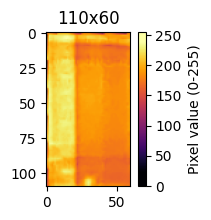

In [14]:
module = modules[0]
print(module)
module.plot()

# Définition des extracteurs

In [15]:
from sklearn.base import BaseEstimator, TransformerMixin
import time

## Indicateurs statistiques "basiques"

In [16]:
# Transformeur qui renvoie le dataframe des indicateurs statistiques
class BaseStatsExtractor(BaseEstimator, TransformerMixin):
    def __init__(self):
        # On détermine le nom des features statistiques à extraire
        self.feature_names_ = PVModule.get_stats_feature_names()

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # On va récupérer les dict stats
        stats_dicts = []
        # On parcourt les chemins des images
        for img_path in X['Chemin']:
            # Récupération de l'objet PVModule correspondant
            module = PVModule.get_module(image_path=img_path)
            # Stockage du dict stats
            module.extract_stats()
            stats_dicts.append(module.stats)
        # On renvoie le dataframe des dict stats
        return pd.DataFrame.from_records(stats_dicts, index=X.index, columns=self.feature_names_)
    
    # Pour récupération du nom des features créées
    def get_feature_names_out(self, input_features=None):
        return self.feature_names_

Pour gagner du temps pendant l'entraînement des pipelines, on lance l'extraction des indicateurs statistiques.

In [17]:
start  = time.time()

for module in PVModule.get_known_modules():
    module.extract_stats()

end = time.time()
elapsed = end - start

print(f"Temps nécessaire : {elapsed/60:.2f} minutes ({elapsed/len(modules)} secondes par module)")

Temps nécessaire : 0.38 minutes (0.004278439982368866 secondes par module)


## Histogramme

In [18]:
# Transformeur qui renvoie le dataframe des indicateurs statistiques
class HistogramExtractor(BaseEstimator, TransformerMixin):
    def __init__(self):
        # On détermine le nom des features statistiques à extraire
        self.feature_names_ = PVModule.get_histogram_feature_names()

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # On va récupérer les vecteurs histogramme
        histo_dicts = []
        # On parcourt les chemins des images
        for img_path in X['Chemin']:
            # Récupération de l'objet PVModule correspondant
            module = PVModule.get_module(image_path=img_path)
            module.extract_histogram()
            # Stockage du dict histogramme
            histo_dicts.append(module.histogram_dict)
        # On renvoie le dataframe des vecteurs stats
        return pd.DataFrame.from_records(histo_dicts, index=X.index, columns=self.feature_names_)
    
    # Pour récupération du nom des features créées
    def get_feature_names_out(self, input_features=None):
        return self.feature_names_

Pour gagner du temps pendant l'entraînement des pipelines, on lance l'extraction des histogrammes.

In [19]:
start  = time.time()

for module in PVModule.get_known_modules():
    module.extract_histogram()

end = time.time()
elapsed = end - start

print(f"Temps nécessaire : {elapsed/60:.2f} minutes ({elapsed/len(modules)} secondes par module)")

Temps nécessaire : 0.04 minutes (0.00046966561845913056 secondes par module)


## Vecteurs GLCM 

In [20]:
# Transformeur qui renvoie le dataframe des caractéristiques GLCM
class GLCMExtractor(BaseEstimator, TransformerMixin):
    def __init__(self):
        # On détermine le nom des features GLCM à extraire
        self.feature_names_ = PVModule.get_glcm_feature_names()

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # On va calculer les vecteurs GLCM
        glcm_vector_dicts = []
        # On parcourt les chemins des images
        for img_path in X['Chemin']:
            # Récupération de l'objet PVModule correspondant
            module = PVModule.get_module(image_path=img_path)
            # Extraction et stockage du vecteur GLCM
            module.extract_glcm()
            glcm_vector_dicts.append(module.glcm_vector)
        # On renvoie le dataframe des vecteurs GLCM
        return pd.DataFrame.from_records(glcm_vector_dicts, index=X.index, columns=self.feature_names_)
    
    # Pour récupération du nom des features créées
    def get_feature_names_out(self, input_features=None):
        return self.feature_names_

Pour gagner du temps pendant l'entraînement des pipelines, on lance l'extraction des vecteurs GLCM.

In [21]:
start  = time.time()

for module in PVModule.get_known_modules():
    module.extract_glcm()

end = time.time()
elapsed = end - start

print(f"Temps nécessaire : {elapsed/60:.2f} minutes ({elapsed/len(modules)} secondes par module)")

Temps nécessaire : 2.73 minutes (0.03067349083372697 secondes par module)


## Densité de contours

In [22]:
# Transformeur qui renvoie la densité de contours
class EdgeDensityExtractor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.feature_names_ = PVModule.get_edge_density_feature_names()

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # On va calculer la densité de contours pour chaque module PV
        edge_densities = []
        # On parcourt les chemins des images
        for img_path in X['Chemin']:
            # Récupération de l'objet PVModule correspondant
            module = PVModule.get_module(image_path=img_path)
            # Extraction et stockage du vecteur GLCM
            module.extract_edge_density()
            edge_densities.append(module.edge_density)
        # On renvoie le dataframe des densités de contours
        return pd.DataFrame(edge_densities, index=X.index, columns=self.feature_names_)
    
    # Pour récupération du nom des features créées
    def get_feature_names_out(self, input_features=None):
        return self.feature_names_

Pour gagner du temps pendant l'entraînement des pipelines, on lance l'extraction des densités de contours.

In [23]:
start  = time.time()

for module in PVModule.get_known_modules():
    module.extract_edge_density()

end = time.time()
elapsed = end - start

print(f"Temps nécessaire : {elapsed/60:.2f} minutes ({elapsed/len(modules)} secondes par module)")

Temps nécessaire : 0.01 minutes (0.00010306359945320824 secondes par module)


## Entropie

In [24]:
# Transformeur qui renvoie les caractéristiques de l'entropie de la matrice de températures du module
class EntropyExtractor(BaseEstimator, TransformerMixin):
    def __init__(self):
        # On détermine le nom des features Entropie à extraire
        self.feature_names_ = PVModule.get_entropy_feature_names()

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # On va calculer les vecteurs caractéristiques de l'entropie
        entropy_vectors = []
        # On parcourt les chemins des images
        for img_path in X['Chemin']:
            # Récupération de l'objet PVModule correspondant
            module = PVModule.get_module(image_path=img_path)
            # Extraction et stockage du vecteur de l'entropie
            module.extract_entropy()
            entropy_vectors.append(module.entropy_vector)
        # On renvoie le dataframe des vecteurs de l'entropie
        return pd.DataFrame.from_records(entropy_vectors, index=X.index, columns=self.feature_names_)
    
    # Pour récupération du nom des features créées
    def get_feature_names_out(self, input_features=None):
        return self.feature_names_

Pour gagner du temps pendant l'entraînement des pipelines, on lance l'extraction des cartes d'entropie.

In [25]:
start  = time.time()

for module in PVModule.get_known_modules():
    module.extract_entropy()

end = time.time()
elapsed = end - start

print(f"Temps nécessaire : {elapsed/60:.2f} minutes ({elapsed/len(modules)} secondes par module)")

Temps nécessaire : 0.57 minutes (0.00638277810269324 secondes par module)


## Hot spots

In [26]:
# Transformeur qui renvoie les caractéristiques des hot spots de la matrice de températures du module
class HotSpotsExtractor(BaseEstimator, TransformerMixin):
    def __init__(self):
        # On détermine le nom des features 'hot spots' à extraire
        self.feature_names_ = PVModule.get_hot_spots_feature_names()

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # On va calculer les vecteurs caractéristiques de l'entropie
        hot_spots_vectors = []
        # On parcourt les chemins des images
        for img_path in X['Chemin']:
            # Récupération de l'objet PVModule correspondant
            module = PVModule.get_module(image_path=img_path)
            # Extraction et stockage du vecteur des caractéristiques des hot spots
            module.extract_hotspots()
            hot_spots_vectors.append(module.hot_spots_features)
        # On renvoie le dataframe des vecteurs des caractéristiques des hot spots
        return pd.DataFrame.from_records(hot_spots_vectors, index=X.index, columns=self.feature_names_)
    
    # Pour récupération du nom des features créées
    def get_feature_names_out(self, input_features=None):
        return self.feature_names_

Pour gagner du temps pendant l'entraînement des pipelines, on lance l'extraction des hot spots.

In [27]:
start  = time.time()

for module in PVModule.get_known_modules():
    module.extract_hotspots()

end = time.time()
elapsed = end - start

print(f"Temps nécessaire : {elapsed/60:.2f} minutes ({elapsed/len(modules)} secondes par module)")

Temps nécessaire : 0.07 minutes (0.0008132575647176183 secondes par module)


# Définition de l'AlbumentationsOverSampler

D'abord on importe la bibliothèque `albumentations`, puis on initialise un dictionnaire qui va mapper l'ensemble des transformations qui nous intéressent avec leur nom.

In [28]:
import albumentations as A

all_transformations = {}

Enregistrement de l'ensemble des transformations créées à partir de la transformation "ToGray".

In [29]:
TRANSFORM_NAME = "ToGray"
COMP_METHODS = ["weighted_average", "from_lab", "desaturation", "average", "max", "pca"]

transformations = {}

for method_name in COMP_METHODS:

    transformation_name = f"{TRANSFORM_NAME}.{method_name}"
    transformation = A.ToGray(num_output_channels=1,
                              method=method_name,
                              p=1.)

    transformations[transformation_name] = transformation

all_transformations.update(transformations)

Enregistrement de l'ensemble des transformations créées à partir de la transformation "ImageCompression".

In [30]:
TRANSFORM_NAME = "ImgComp"
COMP_METHODS = ["jpeg", "webp"]
TOGRAY_METHODS = {
    "w_avg": "weighted_average",
    "avg": "average",
}
QUALITY = [80, 90]

transformations = {}

for method_name in COMP_METHODS:
    for quality in QUALITY:
        for togray_method_shortname, togray_method_name in TOGRAY_METHODS.items():

            transformation_name = f"{TRANSFORM_NAME}.{method_name}.{quality}.{togray_method_shortname}"
            transformation = A.Compose([
                A.ImageCompression(quality_range=[quality, quality],
                                   compression_type=method_name,                                                                                       
                                   p=1.),
                A.ToGray(num_output_channels=1,
                         method=togray_method_name,
                         p=1.),
            ])

            transformations[transformation_name] = transformation

all_transformations.update(transformations)

Enregistrement de l'ensemble des transformations créées à partir de la transformation "MedianBlur".

In [31]:
TRANSFORM_NAME = "MedianBlur"
BLUR_LIMITS = [3, 5]

transformations = {}

for blur_limit in BLUR_LIMITS:

    transformation_name = f"{TRANSFORM_NAME}.{blur_limit}"
    transformation = A.Compose([
        A.MedianBlur(blur_limit=[blur_limit, blur_limit],
                            p=1.),
        A.ToGray(num_output_channels=1,
                    method="weighted_average",
                    p=1.),
    ])

    transformations[transformation_name] = transformation

all_transformations.update(transformations)

Ici on définit quelles transformations seront appliquées selon la classe de défaut associée à chaque échantillon.

In [32]:
class_transformations = {
    "string short circuit": [
        "ToGray.from_lab",
        "ToGray.average",
        "ImgComp.jpeg.80.w_avg",
        "ImgComp.jpeg.90.w_avg",
        "ImgComp.webp.80.w_avg", 
        "ImgComp.webp.90.w_avg", 
        "ImgComp.jpeg.80.avg",
        "ImgComp.jpeg.90.avg",
        "ImgComp.webp.80.avg", 
        "ImgComp.webp.90.avg", 
        "MedianBlur.3",
    ],
    "break": [
        "ToGray.from_lab",
        "ToGray.average",
        "ImgComp.jpeg.80.w_avg",
        "ImgComp.jpeg.90.w_avg",
        "ImgComp.webp.80.w_avg", 
        "ImgComp.webp.90.w_avg", 
    ],
    "shadow": [
        "ToGray.from_lab",
        "ToGray.average",
    ],
    "Debris cover": [
        "ToGray.from_lab",
        "ToGray.average",
    ],
    "bottom dirt": [
        "ToGray.from_lab",
        "ToGray.average",
    ],
    "short circuit panel": [
        "MedianBlur.3",
    ],
}


In [33]:
import cv2

class AlbumentationsAugmenter:
    
    def __init__(self, 
                 all_transformations: dict,
                 class_transformations: dict,
                 augmented_data_subfolder: str = "augmented",
                 ):
        self.all_transformations = all_transformations
        self.class_transformations = class_transformations
        self.augmented_data_subfolder = augmented_data_subfolder
    
    def augmentation(self, module: PVModule):
        # On récupère la classe du module passé en paramètre
        defect_class = module.status
        # On en déduit la liste des transformations à appliquer
        transformations_list = self.class_transformations.get(defect_class, [])
        # On Récupère les modules "transformés" correspondants
        new_modules = []
        for transformation_name in transformations_list:
            # Définition du chemin de l'image transformée
            class_folder = f"xx{defect_class}"
            new_image_path = (module.image_path.parents[2] 
                              / self.augmented_data_subfolder 
                              / class_folder 
                              / f"{module.image_path.stem}.{transformation_name}.png")
            # Si l'image n'existe pas déjà, on la crée et on la sauvegarde
            if not new_image_path.exists():
                # Transformation
                transformation = self.all_transformations[transformation_name]
                transformed_image = transformation(image=module.color_array)['image']
                # Sauvegarde de l'image transformée
                new_image_path.parent.mkdir(exist_ok=True, parents=True)
                cv2.imwrite(new_image_path, transformed_image)
            # Ensuite on peut charge l'objet PVModule correspondant
            new_modules.append(PVModule.get_module(new_image_path))
        return new_modules

    def resample(self, X, y):
        # On itère sur chaque module du dataset X 
        # pour récupérer le chemin et la classe des nouveaux modules "augmentés"
        all_augmented_modules_dicts = []
        for row in X.itertuples(index=False):
            image_path = Path(row.Chemin)
            module = PVModule.get_module(image_path)
            augmented_modules = self.augmentation(module)
            augmented_modules_dicts = [{
                "Chemin": mod.image_path,
                "Format": mod.format,
                "Train_Test": self.augmented_data_subfolder,
                "Classe": mod.status,
                "Nom": mod.image_path.stem,
            }
                                 for mod in augmented_modules]
            all_augmented_modules_dicts += augmented_modules_dicts

        # On crée le dataframe Xy des modules augmentés
        Xy_augmentation = pd.DataFrame(all_augmented_modules_dicts) 
        # On crée le dataframe X augmenté
        X_augmented = pd.concat([X, Xy_augmentation.drop(columns=["Classe"])], axis=0)
        # On crée le vecteur y augmenté
        y_augmented = pd.concat([y, Xy_augmentation["Classe"]], axis=0)

        return X_augmented, y_augmented
    

On termine en créant le sampler à l'aide de la classe FunctionSampler de la bibliothèque `imblearn`.

In [34]:
from imblearn import FunctionSampler

# Pour que le nom réel du sampler utilisé apparaisse dans l'affichage html du pipeline, 
# on crée une classe 'AlbumentationsOverSampler' qui hérite simplement de la classe 'FunctionSampler' de imblearn
class AlbumentationsOverSampler(FunctionSampler):
    ...

albumentations_oversampler = AlbumentationsOverSampler(
    func=AlbumentationsAugmenter(all_transformations, class_transformations).resample,
    validate=False)


# Séparation du jeu de données


Train, Validation & Test.


In [35]:
TRAIN_SIZE = .8
TEST_SIZE = .2
VALIDATION_SIZE = 1. - (TRAIN_SIZE + TEST_SIZE)
RANDOM_STATE = 42
# RANDOM_STATE = None  # Laisser 'random_state' à None pour obtenir un partage aléatoire non-reproductible

In [36]:
from sep24_cds_pv.features.model_selection import improved_train_test_validation_split

splits = improved_train_test_validation_split(df_pvf10, 
                                              target_col="Classe", 
                                              train_size=TRAIN_SIZE,
                                              validation_size=VALIDATION_SIZE, 
                                              test_size=TEST_SIZE, 
                                              random_state=RANDOM_STATE,
                                              stratify=True,
                                              )

In [37]:
if len(splits) == 6:
    X_train, X_test, X_validation, y_train, y_test, y_validation = splits
else:
    X_train, X_test, y_train, y_test = splits

In [38]:
total_elements = sum([len(split) for split_name, split in zip(splits._fields, splits) if split_name.startswith("y")])

def display_dataset_proportions(dataset: pd.Series):
    display(pd.concat([pd.Series(dataset).value_counts(),
                       pd.Series(dataset).value_counts(normalize=True) * 100],
                      axis=1))


for split_name, split in zip(splits._fields, splits):
    if not split_name.startswith("y"):
        continue
    print("---------------------------------")
    print(f"Split: {split_name}\n")
    nb_elements = len(split)
    print(f"Nombre d'éléments: {nb_elements}")
    print(f"Proportion du jeu complet: {nb_elements/total_elements*100:.2f}%")
    if not split.empty:
        display_dataset_proportions(split)


---------------------------------
Split: y_train

Nombre d'éléments: 4270
Proportion du jeu complet: 79.99%


,count,proportion
Classe,,
healthy panel,1165,27.283372
hot cell,676,15.831382
junction box heat,640,14.988290
substring open circuit,475,11.124122
short circuit panel,341,7.985948
bottom dirt,302,7.072600
Debris cover,268,6.276347
shadow,242,5.667447
break,104,2.435597


---------------------------------
Split: y_test

Nombre d'éléments: 1068
Proportion du jeu complet: 20.01%


,count,proportion
Classe,,
healthy panel,291,27.247191
hot cell,169,15.823970
junction box heat,160,14.981273
substring open circuit,119,11.142322
short circuit panel,86,8.052434
bottom dirt,75,7.022472
Debris cover,67,6.273408
shadow,61,5.711610
break,26,2.434457


---------------------------------
Split: y_validation

Nombre d'éléments: 0
Proportion du jeu complet: 0.00%


## Vérification du fonctionnement du sampler

On vérifie que l'utilisation du sampler permet bien de compenser les classes minoritaires selon les taux d'augmentation définis.

In [39]:
X_train_resampled, y_train_resampled = albumentations_oversampler.fit_resample(X_train, y_train)

In [40]:
display_dataset_proportions(y_train_resampled)

,count,proportion
Classe,,
healthy panel,1165,15.562383
bottom dirt,906,12.102592
Debris cover,804,10.740048
break,728,9.724820
shadow,726,9.698103
string short circuit,684,9.137056
short circuit panel,682,9.110339
hot cell,676,9.030190
junction box heat,640,8.549292


# Modélisation

## Classes complémentaires

### Sélecteur UMAP

A la différence de PCA, UMAP ne prend que des valeurs entières pour le paramètre `n_components`.

Afin d'éviter de demander un nombre de composants supérieur au nombre de features disponibles en entrée, on implémente un transformeur qui adopte le comportement suivant :
- si `n_components` est entier, on le passe tel quel au constructeur UMAP
- si `n_components` est un float, on l'utilise comme ratio du nombre de features initial pour fixer le nombre de features souhaités après réduction

In [41]:
from umap import UMAP
from math import floor

class UMAPSelector(BaseEstimator, TransformerMixin):
    def __init__(self, n_components=2, **kwargs):
        self.n_components = n_components
        self._umap_n_components = None
        for key, value in kwargs.items():
            setattr(self, key, value)
        self.umap = None
        self._is_fitted = False

    def fit(self, X, y=None):

        if isinstance(self.n_components, float):
            if self.n_components > 1. or self.n_components < 0.:
                raise ValueError("If 'n_components' is a float, it must be in the range [0. 1.]!")
            _n_components = floor(X.shape[1] * self.n_components)
        else:
            _n_components = self.n_components
        
        self._umap_n_components = _n_components
        
        params = self.get_params()
        params["n_components"] = self._umap_n_components
        self.umap = UMAP(**params)
        self.umap.fit(X)

        # Mark as fitted
        self._is_fitted = True

        return self

    def transform(self, X):
        return self.umap.transform(X)
    
    def get_params(self, deep=True):
        # return all attributes that are parameters (sklearn convention)
        return {k: v for k, v in self.__dict__.items()
                if not k.startswith('_') and k not in ['umap']}

    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self
    
    def __sklearn_is_fitted__(self):
        return hasattr(self, "_is_fitted") and self._is_fitted

### Wrapper XGBoost

XGBoost ne travaille que sur des valeurs numériques.

Pour pouvoir néanmoins utiliser un classifieur XGBoost comme les autres modèles Scikit-learn, il est nécessaire de le 'wrapper' dans un estimateur qui intègre les étapes d'encodage/décodage des classes de défaut dans le vecteur 'y'.

In [42]:
from xgboost import XGBClassifier
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.exceptions import NotFittedError

class XGBClassifierWithLabelEncoding(BaseEstimator, ClassifierMixin):
    def __init__(self, **xgb_params):
        # Dynamically store XGBoost parameters
        for key, value in xgb_params.items():
            setattr(self, key, value)
        self.encoder = LabelEncoder()
        self.clf = None
        self._is_fitted = False

    def fit(self, X, y):
        y_enc = self.encoder.fit_transform(y)

        # Extract valid XGB params from self
        params = self._get_xgb_params()
        self.clf = XGBClassifier(**params)
        self.clf.fit(X, y_enc)

        # Mark as fitted and expose attributes
        self._is_fitted = True
        self.classes_ = self.encoder.classes_
        self.n_features_in_ = X.shape[1]
        if hasattr(X, "columns"):
            self.feature_names_in_ = X.columns

        return self

    def predict(self, X):
        if not self._is_fitted:
            raise NotFittedError("This estimator is not fitted yet. Call 'fit' first.")
        y_pred_enc = self.clf.predict(X)
        return self.encoder.inverse_transform(y_pred_enc)

    def predict_proba(self, X):
        if not self._is_fitted:
            raise NotFittedError("This estimator is not fitted yet. Call 'fit' first.")
        return self.clf.predict_proba(X)

    def get_params(self, deep=True):
        return {
            k: v for k, v in self.__dict__.items()
            if not k.startswith('_') and k not in ['encoder', 'clf']
        }

    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self

    def _get_xgb_params(self):
        valid_params = XGBClassifier().get_params()
        return {
            k: v for k, v in self.get_params().items()
            if k in valid_params
        }
    
    @property
    def feature_importances_(self):
        if not self._is_fitted:
            raise NotFittedError("This estimator is not fitted yet. Call 'fit' first.")
        return self.clf.feature_importances_

    def __sklearn_is_fitted__(self):
        return hasattr(self, "_is_fitted") and self._is_fitted

## Configuration du pipeline

### Pipeline générique

In [43]:
from imblearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

from sklearn.feature_selection import SelectKBest, VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Pipeline générique
pipe = Pipeline([
    ('sampler', albumentations_oversampler),
    ('features', FeatureUnion([
        ('stats', BaseStatsExtractor()),
        ('histogram', HistogramExtractor()),
        ('glcm', GLCMExtractor()),
        ("edgedensity", EdgeDensityExtractor()),
        ("entropy", EntropyExtractor()),
        ("hotspots", HotSpotsExtractor()),
    ])),
    ('dropper', VarianceThreshold()),
    ('scaler', StandardScaler()),
    ('selector', SelectKBest(k="all")),
    ('model', LogisticRegression(max_iter=1000))
],
# Le paramètre 'memory' permet de mettre en cache les transformeurs après entraînement - on gagne du temps sur le GridSearch
# memory="./cache_pipeline",
# L'ajout de .set_output() permet de manipuler des dataframes pandas au lieu de simples arrays numpy à chaque étape
# Cela permet de conserver les noms des colonnes et d'y voir plus clair 
).set_output(transform="pandas")


In [44]:
pipe[:2].fit_transform(X_train, y_train).shape

(7486, 343)

L'extraction de l'ensemble des features possibles conduit à un dataframe de 343 colonnes.

### Paramétrage

Pour une explication de la méthodologie utilisée pour la recherche des meilleurs paramètres des pipelines, voir la section [Méthodologie](#Methodologie) en début de notebook.

#### Samplers

Paramétrage des samplers à évaluer.

In [45]:
sampler_param_grid = [
    {
        'sampler': [albumentations_oversampler],
    },
    {
        'sampler': ["passthrough"],
    },
    # {
    #     'sampler': [
    #         albumentations_oversampler,
    #         "passthrough",
    #         ],
    # },
]

#### Extracteurs

Paramétrage des extracteurs.

In [46]:
extractors_param_grid = [
    {
        "features__stats": [BaseStatsExtractor()],
        "features__edgedensity": [
            EdgeDensityExtractor(),
            "drop",
            ],
        "features__entropy": [
            EntropyExtractor(),
            "drop",
            ],
        "features__glcm": [
            GLCMExtractor(),
            "drop",
            ],
        "features__histogram": [
            # HistogramExtractor(),
            "drop",
            ],
        "features__hotspots": [
            # HotSpotsExtractor(),
            "drop",
            ],
    },
]

#### Scalers

Paramétrage des scalers.

In [47]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

scaler_param_grid = [
    {    
        "scaler": [
            "passthrough",
            # StandardScaler().set_output(transform="pandas"),
            # MinMaxScaler().set_output(transform="pandas"),
            # RobustScaler().set_output(transform="pandas"),
        ]
    },
]

#### Selecteurs (Réduction)

Paramétrage de la réduction de dimensions.

In [48]:
from sklearn.feature_selection import SelectKBest, SelectPercentile, mutual_info_classif
from sklearn.decomposition import PCA

selector_param_grid = [
    {
        'selector': ['passthrough'],
    },
    # {
    #     # SelectePercentile : approche similaire à SelectKBest
    #     'selector': [SelectPercentile(mutual_info_classif)],
    #     # 'percentile' permet de déterminer le nombre de features à conserver, en pourcentage du nombre initial
    #     'selector__percentile' : [20, 50, 80],
    #     # 'selector__percentile' : [80],
    # },
    # {
    #     # Analyse en Composantes Principales
    #     'selector': [PCA()],
    #     # 'n_components', si donné en float, permet de choisir le ratio de variance expliquée à conserver
    #     'selector__n_components' : [0.9, 0.95, 0.99],
    # },
    # {
    #     # Uniform Manifold Approximation and Projection
    #     # 'selector': [UMAPSelector(random_state=42)],
    #     'selector': [UMAPSelector()],
    #     # 'n_components' permet de choisir le nombre de noyaux cible (nombre de features au final)
    #     # 'selector__n_components' : [0.5, 0.8, 1.],
    #     'selector__n_components' : [0.5, 0.8],
    #     'selector__n_neighbors' : [5, 10, 15],
    #     'selector__min_dist' : [0.5, 0.8, 0.99],
    # },
]

#### Estimateurs

Paramétrage des estimateurs (modèles).

In [49]:
import numpy as np

# Classifieurs à évaluer
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

# Les classifieurs suivants ont été explorés, mais leurs performances globales (métriques d'intérêt vs temps de calcul) 
# n'ont pas été jugées suffisantes pour qu'ils soient conservés dans le notebook
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier
# from sklearn.neural_network import MLPClassifier


model_param_grid = [
    {
        'model': [DecisionTreeClassifier()],
        # Attention : sans random_state fixe, DecisionTree garde une part d'aléatoire et les résultats ne sont pas rigoureusement reproductibles
        'model__random_state': [32],
        "model__max_depth": [None, 12],  # Par défaut: None
        # "model__max_depth": [None, 10, 12, 15],  # Par défaut: None
    },
    # {
    #     'model': [RandomForestClassifier()],
    #     # Attention : sans random_state fixe, RandomForest garde une part d'aléatoire et les résultats ne sont pas rigoureusement reproductibles
    #     'model__random_state': [42],
    #     # Paramètres optimaux trouvés lors de la phase exploratoire
    #     'model__n_estimators': [95],
    #     "model__criterion": ["gini"],
    #     "model__max_depth": [17],
    #     "model__min_samples_split": [2],
    #     "model__min_samples_leaf": [2],
    #     "model__class_weight": ["balanced"],
    #     # Grille d'exploration
    #     # 'model__n_estimators': np.arange(90, 110, 5),
    #     # "model__criterion": ["entropy", "gini", "log_loss"],
    #     # "model__max_depth": [17, 18, 19, 20, None],
    #     # # Paramètres additionnels
    #     # "model__min_samples_split": [2, 5, 10],
    #     # "model__min_samples_leaf": [1, 2, 4],
    #     # "model__class_weight": [None, "balanced"],
    # },
    # {
    #     'model': [DecisionTreeClassifier()],
    #     # Attention : sans random_state fixe, DecisionTree garde une part d'aléatoire et les résultats ne sont pas rigoureusement reproductibles
    #     'model__random_state': [32],
    #     # Paramètres optimaux trouvés lors de la phase exploratoire
    #     "model__max_depth": [12],  # Par défaut: None
    #     "model__min_samples_split": [2],  # Par défaut: 2
    #     "model__min_samples_leaf": [1],  # Par défaut: 1
    #     "model__max_features": [None],  # Par défaut: None
    #     "model__class_weight": [None],  # Par défaut: None
    #     "model__criterion": ["gini"],  # Par défaut: "gini"
    #     # Grille d'exploration
    #     # "model__max_depth": [None, 10, 12, 15, 20],  # Par défaut: None
    #     # "model__min_samples_split": [2, 5, 10, 20, 50],  # Par défaut: 2
    #     # "model__min_samples_leaf": [1, 2, 5, 10, 20],  # Par défaut: 1
    #     # "model__max_features": ["sqrt", "log2", 0.2, 0.5, None],  # Par défaut: None
    #     # "model__class_weight": [None, "balanced"],  # Par défaut: None
    #     # "model__criterion": ["gini", "entropy"],  # Par défaut: "gini"
    # },
    # {
    #     'model': [XGBClassifierWithLabelEncoding()],
    #     # tree_method='auto' et eval_metric='logloss' sont les valeurs par défaut du XGBClassifier
    #     'model__tree_method': ['auto'],
    #     'model__eval_metric': ['logloss'],
    #     # Attention : sans random_state fixe, XGBoost garde une part d'aléatoire et les résultats ne sont pas rigoureusement reproductibles
    #     'model__random_state': [42],
    #     # Paramètres optimaux trouvés lors de la phase exploratoire
    #     'model__max_depth': [6],  # Par défaut: 6
    #     'model__min_child_weight': [1],  # Par défaut: 1
    #     'model__colsample_bytree': [1.],  # Par défaut: 1
    #     'model__subsample': [1.0],  # Par défaut: 1.
    #     'model__learning_rate': [0.3],  # (ou eta) Par défaut: 0.3
    #     'model__n_estimators': [100],  # Par défaut: 100
    #     # Grille d'exploration
    #     # 'model__max_depth': [4, 6, 8],
    #     # 'model__min_child_weight': [1, 6, 12],
    #     # 'model__subsample': [0.5, 0.7, 0.9, 1.0],
    #     # 'model__colsample_bytree': [0.5, 0.7, 0.9, 1.0],
    #     # 'model__n_estimators': [100, 200, 300, 500, 600, 700, 800, 900, 1000],
    #     # 'model__learning_rate': [0.01, 0.05, 0.1, 0.3],
    # },
    # {
    #     'model': [SVC()],
    #     # Paramètres optimaux trouvés lors de la phase exploratoire
    #     'model__C': [10],  # Par défaut: 1.
    #     'model__kernel': ['rbf'],  # Par défaut: 'rbf'
    #     "model__gamma": ["scale"],  # Par défaut: 'scale'
    #     "model__class_weight": ["balanced"],  # Par défaut: None
    #     "model__shrinking": [True],  # Par défaut: True
    #     # Grille d'exploration
    #     # 'model__C': [0.01, 0.1, 1, 10, 100, 1000],
    #     # 'model__kernel': ['linear', 'rbf', 'poly'],
    #     # "model__degree": [2, 3, 4, 5],  # Par défaut: 3 (pour kernel 'poly' seulement)
    #     # "model__gamma": ["scale", "auto", 0.001, 0.1, 0.5, 1.],
    #     # "model__class_weight": ["balanced", None]
    #     # "model__shrinking": [True, False],
    # },
    # {
    #     # Bonnes performances mais plutôt lent
    #     'model': [LGBMClassifier()],
    #     # Paramètres par défaut
    #     "model__objective": ['multiclass'],
    #     # Paramètres optimaux trouvés lors de la phase exploratoire
    #     "model__metric": ['multi_logloss'],  # ou 'multi_error'
    #     "model__num_leaves": [127],  # Par défaut: 31
    #     "model__min_data_in_leaf": [20],  # Par défaut: 20
    #     "model__learning_rate": [0.1],  # Par défaut: 0.1
    #     "model__class_weight": [None],  # Par défaut: None
    #     # Grille d'exploration
    #     # "model__num_leaves": [15, 31, 63, 127],
    #     # "model__min_data_in_leaf": [5, 10, 20, 50, 100],
    #     # "model__learning_rate": [0.01, 0.05, 0.1, 0.2, 0.5],
    #     # "model__class_weight": ["balanced", None]
    #     # "model__metric": ['multi_logloss', 'multi_error'],
    # },
    # {
    #     # Très bonnes performances mais plutôt très lent... l'entraînement doit intégrer une part d'auto-optimisation
    #     'model': [CatBoostClassifier()],
    #     # Attention : sans random_seed fixe, CatBoost garde une part d'aléatoire et les résultats ne sont pas rigoureusement reproductibles
    #     'model__random_seed': [32],
    #     # Grille d'exploration
    #     # Inutile : très bonnes performances avec les paramètres par défaut
    # },
]

### Combinaison de l'ensemble des paramètres

In [50]:
param_grids = []

for model_dict in model_param_grid:
    for extractor_dict in extractors_param_grid:
        for scaler_dict in scaler_param_grid:
            for selector_dict in selector_param_grid:
                for sampler_dict in sampler_param_grid:
                    full_dict = {}
                    full_dict.update(model_dict)
                    full_dict.update(extractor_dict)
                    full_dict.update(scaler_dict)
                    full_dict.update(selector_dict)
                    full_dict.update(sampler_dict)
                    param_grids.append(full_dict)

In [51]:
len(param_grids)

2

### Fonctions d'extraction des caractéristiques du pipeline

In [52]:
# Type de modèle
def extract_model_name(pipeline):
    model = pipeline[5]
    return model.__class__.__name__ if model is not None else 'unknown'

# Sampler
def extract_sampler_name(pipeline):
    sampler = pipeline[0]
    return sampler.__class__.__name__ if not isinstance(sampler, str) else 'noSampling'

# Extracteurs / Features
def extract_extractor_names(pipeline):
    extractors_dict = pipeline[1].named_transformers
    extractor_strings = []
    for feature_key, extractor in extractors_dict.items():
        extractor_string = feature_key.capitalize()
        extractor_string = f"no{extractor_string}" if isinstance(extractor, str) else extractor_string
        extractor_strings.append(extractor_string)
    return "_".join(extractor_strings)

# Scaler
def extract_scaler_name(pipeline):
    scaler = pipeline[3]
    return scaler.__class__.__name__ if not isinstance(scaler, str) else 'noScaling'

# Selector
def extract_selector_name(pipeline):
    selector = pipeline[4]
    return selector.__class__.__name__ if not isinstance(selector, str) else 'noReduction'

# Concaténation de l'ensemble des caractéristiques
def get_pipeline_shortdescription(pipeline):

    model_name = extract_model_name(pipeline)
    sampler_name = extract_sampler_name(pipeline)
    features = extract_extractor_names(pipeline)
    scaler_name = extract_scaler_name(pipeline)
    selector_name = extract_selector_name(pipeline)
    
    return f"{model_name}_{sampler_name}_{features}_{scaler_name}_{selector_name}"


## Activation de MLflow

In [53]:
import arrow

current_dt = arrow.utcnow()

if ACTIVATE_MLFLOW:

    import mlflow
    import logging

    # Configuration du serveur MLflow
    mlflow.set_tracking_uri(MLFLOW_URI)

    # Définition des noms des Experiments
    MLFLOW_EXPERIMENT_NAME_PATTERN = "PVF10_MLstats_{suffix}"

    # Suppression des messages de log émis par MLflow
    mlflow_logger = logging.getLogger('mlflow')
    mlflow_logger.setLevel(logging.WARNING)
    logging.getLogger('mlflow.utils.requirements_utils').setLevel(logging.ERROR)
    

## Validation croisée

### Fonction d'exécution du GridSearchCV

In [54]:
import time
import tempfile
from pprint import pprint
from sklearn.base import clone
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

from sep24_cds_pv.features.model_selection import display_results


# Exécution du GridSearch
def execute_gridsearch(pipeline_param_grid):

    start = time.time()

    base_model = pipeline_param_grid.get('model')[0]
    model_name = base_model.__class__.__name__
    
    print("-------------------------------------------------------------------------")
    print(f"Evaluation des pipelines basés sur {model_name}")
    print("-------------------------------------------------------------------------")
    print()

    grid = GridSearchCV(estimator=pipe, 
                        param_grid=pipeline_param_grid, 
                        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                        scoring={'accuracy': 'accuracy','f1_macro': 'f1_macro'},
                        refit='f1_macro', 
                        return_train_score=True,
                        n_jobs=-1, 
                        verbose=1)
    grid.fit(X_train, y_train)

    end = time.time()
    print(f"Temps nécessaire : {(end - start)/60:.2f} minutes")

    display(grid)

    # Affichage des résultats (classement par f1-score macro)
    print()
    print("Résultats obtenus par le GridSearch (sur le jeu d'apprentissage) :")
    print("Meilleurs paramètres (f1 macro) : ")
    pprint(grid.best_params_)
    print("Meilleur score (f1 macro): ", grid.best_score_)

    results = pd.DataFrame(grid.cv_results_)

    # Ajout de la description macro de chaque pipeline évalué
    for idx, params in results['params'].items():
        c_pipe = clone(grid.estimator)
        c_pipe.set_params(**params)
        c_pipe_description = get_pipeline_shortdescription(c_pipe)
        results.loc[idx, "pipeline_description"] = c_pipe_description

    # Ajout du nombre de features avant et après sélection (réduction de dimension), pour le meilleur estimateur
    best_idx = grid.best_index_
    n_features_pre_selector = grid.best_estimator_[:4].transform(X_test).shape[1]
    results.loc[best_idx, "n_features_pre_selector"] = n_features_pre_selector
    n_features_post_selector = grid.best_estimator_[:5].transform(X_test).shape[1]
    results.loc[best_idx, "n_features_post_selector"] = n_features_post_selector

    # Affichage des résultats
    display(results[['pipeline_description',
                     'rank_test_f1_macro',
                     'params', 
                     'mean_fit_time', 'mean_score_time', 
                     'mean_test_accuracy', 'std_test_accuracy', 
                     'mean_test_f1_macro', 'std_test_f1_macro',
                     ]]
            .sort_values('mean_test_f1_macro', ascending=False))

    return grid, results


### Fonctions de log de MLflow

In [55]:
if ACTIVATE_MLFLOW:

    import mlflow.sklearn
    import mlflow.sklearn.utils

    def mlflow_log_standard(current_results, i):
        """Log info for standard run"""

        params = current_results.loc[i, 'params']

        # Log pipeline description as tag
        mlflow.set_tag("description", current_results.loc[i, "pipeline_description"])

        # Log hyperparameters
        mlflow.log_params(params)

        # Log mean and std scores, mean and std times, ranks, split_scores, n_features
        for name in current_results.columns:
            if name.startswith(("mean_test_", "rank_test_", "std_test_", "n_features_")) or name.endswith("_time"):
                mlflow.log_metric(name, current_results.loc[i, name])

        mlflow.set_tag("is_best", False)


    def mlflow_log_best(child_run, current_results, i, current_grid, figure=None, report_text=None, report_dict=None):
        """Log info for best run"""

        # Log the model
        best_model = current_grid.best_estimator_
        mlflow.sklearn.log_model(best_model, artifact_path="model", input_example=X_train[["Chemin"]])
        mlflow.set_tag("is_best", True)

        # Log pipeline html representation
        mlflow.sklearn.utils._log_estimator_html(child_run.info.run_id, best_model)

        # Log test metrics, if any
        for score_name in [name for name in current_results.columns if name.startswith("test_")]:
            mlflow.log_metric(score_name, current_results.loc[i, score_name])
        
        # Log classification matrix
        if figure is not None:
            with tempfile.TemporaryDirectory() as tmp_dir:
                cm_path = Path(tmp_dir) / "confusion_matrix.png"
                figure.savefig(cm_path)
                mlflow.log_artifact(cm_path)
        
        # Log classification reports
        if report_text is not None:
            mlflow.log_text(report_text, "classification_report.txt")
        if report_dict is not None:
            mlflow.log_dict(report_dict, "classification_report.yaml")

        mlflow.set_tag("is_best", True)


### Exécution du GridSearchCV

In [56]:
from joblib import parallel_backend
from sklearn.exceptions import ConvergenceWarning
import warnings

results_list = []

mlflow_client = mlflow.tracking.MlflowClient()

for param_idx, param_grid in enumerate(param_grids):

    print()
    print(f"Param_grid {param_idx+1}/{len(param_grids)}")

    # with parallel_backend('loky'):  # Paramétrage par défaut - multiprocessing
    with parallel_backend('threading'):  # Important pour permettre le "partage" de la classe PVModule entre tous les jobs

        with warnings.catch_warnings():

            # Filtrage des ConvergenceWarnings émis par scikit-learn pour LogisticRegression
            warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
            # Filtrage des FutureWarnings émis par scikit-learn / En version <=0.5.7, UMAP utilise un nom de paramètre prochainement déprécié
            warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn", message=r"^'force_all_finite' was renamed.*")
            # Filtrage des UserWarnings émis par joblib (probablement une opération de lecture du cache qui dure trop longtemps)
            warnings.filterwarnings("ignore", category=UserWarning, module="joblib", message=r"^Persisting input arguments took.*")
        
            # Exécution du GridSearchCV
            current_grid, current_results = execute_gridsearch(param_grid)

    # Ajout des résultats courants à la liste
    results_list.append(current_results)

    if ACTIVATE_MLFLOW:

        base_model = param_grid.get('model')[0]
        model_name = base_model.__class__.__name__
        
        mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME_PATTERN.format(suffix=model_name,
                                                                    # date_string=current_dt.format('YYYYMMDD_HHmm'),
                                                                    # date_string=current_dt.format('YYYYMMDD'),
                                                                    )
                              )
        mlflow.set_experiment_tag("estimator", model_name)

        with mlflow.start_run() as parent_run:

            n_candidates = len(current_results['params'])
            best_index = current_grid.best_index_

            # Log de la grille de paramètres et des paramètres additionnels
            mlflow.log_params(param_grid)
            mlflow.log_param("cv", current_grid.cv)
            mlflow.log_param("scoring", current_grid.scoring)
            mlflow.log_param("total_candidates", n_candidates)

            # Log du dataframe de l'ensemble des résultats
            with tempfile.TemporaryDirectory() as tmp_dir:
                results_path = Path(tmp_dir) / "cv_results.csv"
                current_results.to_csv(results_path, index=False)
                mlflow.log_artifact(results_path)

            for i in range(n_candidates):

                # Si on ne souhaite logger que le "best run"
                if i == best_index:

                    with mlflow.start_run(run_name=f"{parent_run.info.run_name}_{i}", nested=True) as child_run:
                        mlflow_log_standard(current_results, i)
                        mlflow_log_best(child_run, current_results, i, current_grid)

                # Si on souhaite logger tous les runs
                elif MLFLOW_LOG_ALL_RUNS:

                    with mlflow.start_run(run_name=f"{parent_run.info.run_name}_{i}", nested=True) as child_run:
                        mlflow_log_standard(current_results, i)




Param_grid 1/2
-------------------------------------------------------------------------
Evaluation des pipelines basés sur DecisionTreeClassifier
-------------------------------------------------------------------------

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Temps nécessaire : 0.64 minutes


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('sampler',
                                        AlbumentationsOverSampler(func=<bound method AlbumentationsAugmenter.resample of <__main__.AlbumentationsAugmenter object at 0x0000024F1F1D3500>>,
                                                                  validate=False)),
                                       ('features',
                                        FeatureUnion(transformer_list=[('stats',
                                                                        BaseStatsExtractor()),
                                                                       ('histogra...
                         'model__random_state': [32],
                         'sampler': [AlbumentationsOverSampler(func=<bound method AlbumentationsAugmenter.resample of <__main__.AlbumentationsAugmenter object at 0x0000024F1F1D3500>>,
                                                               validate=False)],
                         'scaler': ['passthrough'],
                         'selector': ['passthrough']},
             refit='f1_macro', return_train_score=True,
             scoring={'accuracy': 'accuracy', 'f1_macro': 'f1_macro'},
             verbose=1)


Résultats obtenus par le GridSearch (sur le jeu d'apprentissage) :
Meilleurs paramètres (f1 macro) : 
{'features__edgedensity': EdgeDensityExtractor(),
 'features__entropy': 'drop',
 'features__glcm': GLCMExtractor(),
 'features__histogram': 'drop',
 'features__hotspots': 'drop',
 'features__stats': BaseStatsExtractor(),
 'model': DecisionTreeClassifier(),
 'model__max_depth': 12,
 'model__random_state': 32,
 'sampler': AlbumentationsOverSampler(func=<bound method AlbumentationsAugmenter.resample of <__main__.AlbumentationsAugmenter object at 0x0000024F1F1D3500>>,
                          validate=False),
 'scaler': 'passthrough',
 'selector': 'passthrough'}
Meilleur score (f1 macro):  0.5725982344094508


,pipeline_description,rank_test_f1_macro,params,mean_fit_time,mean_score_time,mean_test_accuracy,std_test_accuracy,mean_test_f1_macro,std_test_f1_macro
5,DecisionTreeClassifier_AlbumentationsOverSampl...,1,{'features__edgedensity': EdgeDensityExtractor...,4.379064,0.548136,0.649649,0.012942,0.572598,0.015356
1,DecisionTreeClassifier_AlbumentationsOverSampl...,2,{'features__edgedensity': EdgeDensityExtractor...,5.314373,0.879491,0.646136,0.014985,0.567531,0.020930
13,DecisionTreeClassifier_AlbumentationsOverSampl...,3,"{'features__edgedensity': 'drop', 'features__e...",4.152734,0.203289,0.628337,0.016503,0.563399,0.019017
9,DecisionTreeClassifier_AlbumentationsOverSampl...,4,"{'features__edgedensity': 'drop', 'features__e...",4.630251,0.304436,0.634895,0.020847,0.558917,0.024918
4,DecisionTreeClassifier_AlbumentationsOverSampl...,5,{'features__edgedensity': EdgeDensityExtractor...,4.482975,0.513898,0.615222,0.007428,0.552364,0.006157
0,DecisionTreeClassifier_AlbumentationsOverSampl...,6,{'features__edgedensity': EdgeDensityExtractor...,5.493550,0.988505,0.614754,0.007661,0.547967,0.014309
12,DecisionTreeClassifier_AlbumentationsOverSampl...,7,"{'features__edgedensity': 'drop', 'features__e...",4.294868,0.138695,0.610304,0.010614,0.546275,0.015803
8,DecisionTreeClassifier_AlbumentationsOverSampl...,8,"{'features__edgedensity': 'drop', 'features__e...",5.161277,0.438984,0.609836,0.026552,0.544895,0.032366
3,DecisionTreeClassifier_AlbumentationsOverSampl...,9,{'features__edgedensity': EdgeDensityExtractor...,4.510227,0.469789,0.618970,0.010696,0.539447,0.019806
7,DecisionTreeClassifier_AlbumentationsOverSampl...,10,{'features__edgedensity': EdgeDensityExtractor...,4.069799,0.421487,0.613817,0.026083,0.535821,0.025308


🏃 View run zealous-penguin-460_5 at: http://mlflow.philippemarechal.org:35000/#/experiments/269427897650446482/runs/2f99809f153e4db4b78091223e3340b2
🧪 View experiment at: http://mlflow.philippemarechal.org:35000/#/experiments/269427897650446482
🏃 View run zealous-penguin-460 at: http://mlflow.philippemarechal.org:35000/#/experiments/269427897650446482/runs/b02da4643656485ca1ccad521154d986
🧪 View experiment at: http://mlflow.philippemarechal.org:35000/#/experiments/269427897650446482

Param_grid 2/2
-------------------------------------------------------------------------
Evaluation des pipelines basés sur DecisionTreeClassifier
-------------------------------------------------------------------------

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Temps nécessaire : 0.29 minutes


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('sampler',
                                        AlbumentationsOverSampler(func=<bound method AlbumentationsAugmenter.resample of <__main__.AlbumentationsAugmenter object at 0x0000024F1F1D3500>>,
                                                                  validate=False)),
                                       ('features',
                                        FeatureUnion(transformer_list=[('stats',
                                                                        BaseStatsExtractor()),
                                                                       ('histogra...
                         'features__hotspots': ['drop'],
                         'features__stats': [BaseStatsExtractor()],
                         'model': [DecisionTreeClassifier(max_depth=12,
                                                          random_state=32)],
                         'model__max_depth': [None, 12],
                         'model__random_state': [32],
                         'sampler': ['passthrough'], 'scaler': ['passthrough'],
                         'selector': ['passthrough']},
             refit='f1_macro', return_train_score=True,
             scoring={'accuracy': 'accuracy', 'f1_macro': 'f1_macro'},
             verbose=1)


Résultats obtenus par le GridSearch (sur le jeu d'apprentissage) :
Meilleurs paramètres (f1 macro) : 
{'features__edgedensity': EdgeDensityExtractor(),
 'features__entropy': 'drop',
 'features__glcm': GLCMExtractor(),
 'features__histogram': 'drop',
 'features__hotspots': 'drop',
 'features__stats': BaseStatsExtractor(),
 'model': DecisionTreeClassifier(max_depth=12, random_state=32),
 'model__max_depth': 12,
 'model__random_state': 32,
 'sampler': 'passthrough',
 'scaler': 'passthrough',
 'selector': 'passthrough'}
Meilleur score (f1 macro):  0.6040569477967261


,pipeline_description,rank_test_f1_macro,params,mean_fit_time,mean_score_time,mean_test_accuracy,std_test_accuracy,mean_test_f1_macro,std_test_f1_macro
5,DecisionTreeClassifier_noSampling_Stats_noHist...,1,{'features__edgedensity': EdgeDensityExtractor...,1.169475,0.655978,0.692506,0.015492,0.604057,0.022655
13,DecisionTreeClassifier_noSampling_Stats_noHist...,2,"{'features__edgedensity': 'drop', 'features__e...",1.115469,0.454977,0.679391,0.007157,0.601530,0.009364
4,DecisionTreeClassifier_noSampling_Stats_noHist...,3,{'features__edgedensity': EdgeDensityExtractor...,1.094440,0.584104,0.671429,0.012861,0.590137,0.024117
0,DecisionTreeClassifier_noSampling_Stats_noHist...,4,{'features__edgedensity': EdgeDensityExtractor...,1.730703,0.726952,0.666511,0.012664,0.585836,0.019993
1,DecisionTreeClassifier_noSampling_Stats_noHist...,5,{'features__edgedensity': EdgeDensityExtractor...,1.623655,0.650306,0.681967,0.014730,0.578426,0.023675
12,DecisionTreeClassifier_noSampling_Stats_noHist...,6,"{'features__edgedensity': 'drop', 'features__e...",0.911694,0.475366,0.662529,0.012155,0.576927,0.017647
9,DecisionTreeClassifier_noSampling_Stats_noHist...,7,"{'features__edgedensity': 'drop', 'features__e...",1.331443,0.623467,0.670960,0.018216,0.575168,0.015353
3,DecisionTreeClassifier_noSampling_Stats_noHist...,8,{'features__edgedensity': EdgeDensityExtractor...,1.243346,0.693272,0.673068,0.018237,0.572510,0.014852
8,DecisionTreeClassifier_noSampling_Stats_noHist...,9,"{'features__edgedensity': 'drop', 'features__e...",1.799038,0.451226,0.647775,0.016164,0.571781,0.020257
7,DecisionTreeClassifier_noSampling_Stats_noHist...,10,{'features__edgedensity': EdgeDensityExtractor...,0.936514,0.442253,0.664169,0.026386,0.561897,0.027009


🏃 View run gifted-frog-507_5 at: http://mlflow.philippemarechal.org:35000/#/experiments/269427897650446482/runs/df1327d72e7c4b52894c7da81fd114b7
🧪 View experiment at: http://mlflow.philippemarechal.org:35000/#/experiments/269427897650446482
🏃 View run gifted-frog-507 at: http://mlflow.philippemarechal.org:35000/#/experiments/269427897650446482/runs/335e40c27be349b1b0722cad05ef85bc
🧪 View experiment at: http://mlflow.philippemarechal.org:35000/#/experiments/269427897650446482


## Compilation des résultats

In [57]:
results_df = pd.concat(results_list, axis=0).reset_index(drop=True).sort_values("mean_test_f1_macro", ascending=False)
display(results_df)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_features__edgedensity,param_features__entropy,param_features__glcm,param_features__histogram,param_features__hotspots,param_features__stats,...,split0_train_f1_macro,split1_train_f1_macro,split2_train_f1_macro,split3_train_f1_macro,split4_train_f1_macro,mean_train_f1_macro,std_train_f1_macro,pipeline_description,n_features_pre_selector,n_features_post_selector
21,1.169475,0.065723,0.655978,0.135480,EdgeDensityExtractor(),drop,GLCMExtractor(),drop,drop,BaseStatsExtractor(),...,0.877729,0.898237,0.910899,0.890094,0.890494,0.893490,0.010904,DecisionTreeClassifier_noSampling_Stats_noHist...,49.0,49.0
29,1.115469,0.187685,0.454977,0.106049,drop,drop,GLCMExtractor(),drop,drop,BaseStatsExtractor(),...,0.909805,0.905117,0.905278,0.902453,0.914641,0.907459,0.004298,DecisionTreeClassifier_noSampling_Stats_noHist...,NaN,NaN
20,1.094440,0.156524,0.584104,0.116412,EdgeDensityExtractor(),drop,GLCMExtractor(),drop,drop,BaseStatsExtractor(),...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,DecisionTreeClassifier_noSampling_Stats_noHist...,NaN,NaN
16,1.730703,0.033852,0.726952,0.157762,EdgeDensityExtractor(),EntropyExtractor(),GLCMExtractor(),drop,drop,BaseStatsExtractor(),...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,DecisionTreeClassifier_noSampling_Stats_noHist...,NaN,NaN
17,1.623655,0.018558,0.650306,0.200558,EdgeDensityExtractor(),EntropyExtractor(),GLCMExtractor(),drop,drop,BaseStatsExtractor(),...,0.860054,0.899593,0.918023,0.884218,0.895075,0.891393,0.019097,DecisionTreeClassifier_noSampling_Stats_noHist...,NaN,NaN
28,0.911694,0.159750,0.475366,0.103976,drop,drop,GLCMExtractor(),drop,drop,BaseStatsExtractor(),...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,DecisionTreeClassifier_noSampling_Stats_noHist...,NaN,NaN
25,1.331443,0.264831,0.623467,0.181817,drop,EntropyExtractor(),GLCMExtractor(),drop,drop,BaseStatsExtractor(),...,0.886510,0.885076,0.932693,0.902018,0.889683,0.899196,0.017781,DecisionTreeClassifier_noSampling_Stats_noHist...,NaN,NaN
5,4.379064,0.162634,0.548136,0.217231,EdgeDensityExtractor(),drop,GLCMExtractor(),drop,drop,BaseStatsExtractor(),...,0.834215,0.827827,0.845953,0.826372,0.836192,0.834112,0.006985,DecisionTreeClassifier_AlbumentationsOverSampl...,49.0,49.0
19,1.243346,0.076173,0.693272,0.140830,EdgeDensityExtractor(),EntropyExtractor(),drop,drop,drop,BaseStatsExtractor(),...,0.847204,0.853895,0.892365,0.859820,0.876949,0.866046,0.016450,DecisionTreeClassifier_noSampling_Stats_noHist...,NaN,NaN
24,1.799038,0.173206,0.451226,0.132315,drop,EntropyExtractor(),GLCMExtractor(),drop,drop,BaseStatsExtractor(),...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,DecisionTreeClassifier_noSampling_Stats_noHist...,NaN,NaN


## Sauvegarde du fichier de résultats

Dans le cas où MLflow n'est pas utilisé, on peut stocker l'ensemble des résultats de recherche dans des fichiers nommés en fonction de la date et de l'heure d'exécution.

In [58]:
RESULTS_DIR = "./ML_stats_results"
results_dirpath = Path(RESULTS_DIR)

if not results_dirpath.exists():
    results_dirpath.mkdir()

filepath = results_dirpath / f"results_{current_dt.format('YYYYMMDD_HHmm')}.csv"
print(f"Sauvegarde du fichier {filepath}")
results_df.to_csv(filepath, index=False, sep=";")

Sauvegarde du fichier ML_stats_results\results_20250618_1739.csv


# Exploration des résultats

In [59]:
results_df['model_name'] = results_df['param_model'].apply(lambda model_object: model_object.__class__.__name__)

# Pour l'infobulle : construire une chaîne avec tous les paramètres
def format_params(param_dict):
    params_str = '<br>'.join(f"   {k}={v}" for k, v in param_dict.items() if k != "model")
    return f"<br>{params_str}"

results_df['params_str'] = results_df['params'].apply(format_params)


In [60]:
results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_features__edgedensity,param_features__entropy,param_features__glcm,param_features__histogram,param_features__hotspots,param_features__stats,...,split2_train_f1_macro,split3_train_f1_macro,split4_train_f1_macro,mean_train_f1_macro,std_train_f1_macro,pipeline_description,n_features_pre_selector,n_features_post_selector,model_name,params_str
21,1.169475,0.065723,0.655978,0.135480,EdgeDensityExtractor(),drop,GLCMExtractor(),drop,drop,BaseStatsExtractor(),...,0.910899,0.890094,0.890494,0.893490,0.010904,DecisionTreeClassifier_noSampling_Stats_noHist...,49.0,49.0,DecisionTreeClassifier,<br> features__edgedensity=EdgeDensityExtrac...
29,1.115469,0.187685,0.454977,0.106049,drop,drop,GLCMExtractor(),drop,drop,BaseStatsExtractor(),...,0.905278,0.902453,0.914641,0.907459,0.004298,DecisionTreeClassifier_noSampling_Stats_noHist...,NaN,NaN,DecisionTreeClassifier,<br> features__edgedensity=drop<br> featur...
20,1.094440,0.156524,0.584104,0.116412,EdgeDensityExtractor(),drop,GLCMExtractor(),drop,drop,BaseStatsExtractor(),...,1.000000,1.000000,1.000000,1.000000,0.000000,DecisionTreeClassifier_noSampling_Stats_noHist...,NaN,NaN,DecisionTreeClassifier,<br> features__edgedensity=EdgeDensityExtrac...
16,1.730703,0.033852,0.726952,0.157762,EdgeDensityExtractor(),EntropyExtractor(),GLCMExtractor(),drop,drop,BaseStatsExtractor(),...,1.000000,1.000000,1.000000,1.000000,0.000000,DecisionTreeClassifier_noSampling_Stats_noHist...,NaN,NaN,DecisionTreeClassifier,<br> features__edgedensity=EdgeDensityExtrac...
17,1.623655,0.018558,0.650306,0.200558,EdgeDensityExtractor(),EntropyExtractor(),GLCMExtractor(),drop,drop,BaseStatsExtractor(),...,0.918023,0.884218,0.895075,0.891393,0.019097,DecisionTreeClassifier_noSampling_Stats_noHist...,NaN,NaN,DecisionTreeClassifier,<br> features__edgedensity=EdgeDensityExtrac...
28,0.911694,0.159750,0.475366,0.103976,drop,drop,GLCMExtractor(),drop,drop,BaseStatsExtractor(),...,1.000000,1.000000,1.000000,1.000000,0.000000,DecisionTreeClassifier_noSampling_Stats_noHist...,NaN,NaN,DecisionTreeClassifier,<br> features__edgedensity=drop<br> featur...
25,1.331443,0.264831,0.623467,0.181817,drop,EntropyExtractor(),GLCMExtractor(),drop,drop,BaseStatsExtractor(),...,0.932693,0.902018,0.889683,0.899196,0.017781,DecisionTreeClassifier_noSampling_Stats_noHist...,NaN,NaN,DecisionTreeClassifier,<br> features__edgedensity=drop<br> featur...
5,4.379064,0.162634,0.548136,0.217231,EdgeDensityExtractor(),drop,GLCMExtractor(),drop,drop,BaseStatsExtractor(),...,0.845953,0.826372,0.836192,0.834112,0.006985,DecisionTreeClassifier_AlbumentationsOverSampl...,49.0,49.0,DecisionTreeClassifier,<br> features__edgedensity=EdgeDensityExtrac...
19,1.243346,0.076173,0.693272,0.140830,EdgeDensityExtractor(),EntropyExtractor(),drop,drop,drop,BaseStatsExtractor(),...,0.892365,0.859820,0.876949,0.866046,0.016450,DecisionTreeClassifier_noSampling_Stats_noHist...,NaN,NaN,DecisionTreeClassifier,<br> features__edgedensity=EdgeDensityExtrac...
24,1.799038,0.173206,0.451226,0.132315,drop,EntropyExtractor(),GLCMExtractor(),drop,drop,BaseStatsExtractor(),...,1.000000,1.000000,1.000000,1.000000,0.000000,DecisionTreeClassifier_noSampling_Stats_noHist...,NaN,NaN,DecisionTreeClassifier,<br> features__edgedensity=drop<br> featur...


In [61]:
import plotly.express as px

def display_graphs(results_df, scores, x_axis, score_of_interest):

    # Trouver l’indice du meilleur modèle
    best_idx = results_df[score_of_interest].idxmax()

    results_df_highlight = results_df.copy()
    results_df_highlight["highlight"] = results_df_highlight.index == best_idx
    results_df_highlight = results_df_highlight.sort_values("highlight")

    # Création du graphique interactif pour chaque cas
    for score, title in scores.items():

        size_column = score.replace("mean", "std")
        size_column = size_column if size_column in results_df_highlight.columns else None

        fig = px.scatter(
            results_df_highlight,
            x=x_axis,
            y=score,
            color='highlight',
            size=size_column,
            hover_data={
                'model_name': True,
                'params_str': True,
                x_axis: ':.2f',
                score: ':.4f',
            },
            title=title,
        )
        fig.update_traces(showlegend=False)
        fig.show()


In [62]:
import plotly.express as px

# Définition des scores à afficher en fonction du temps
scores = {
    "mean_test_accuracy": "⏱️ Précision vs Temps - Résultats du GridSearchCV sur les jeux de 'test' du GridSearch (folds extraits du jeu 'train')",
    "mean_test_f1_macro": "⏱️ F1_macro vs Temps - Résultats du GridSearchCV sur les jeux de 'test' du GridSearch (folds extraits du jeu 'train')",
}

SCORE_OF_INTEREST = "mean_test_f1_macro"

# Trouver l’indice du meilleur modèle
best_idx = results_df[SCORE_OF_INTEREST].idxmax()

results_df["highlight"] = results_df.index == best_idx

# Création du graphique interactif pour chaque cas
for score, title in scores.items():

    size_column = score.replace("mean", "std")
    size_column = size_column if size_column in results_df.columns else None

    fig = px.scatter(
        results_df.sort_values("highlight"),
        x="mean_fit_time",
        y=score,
        color='highlight',
        size=size_column,
        hover_data={
            'model_name': True,
            'params_str': True,
            "mean_fit_time": ':.2f',
            score: ':.4f',
        },
        title=title,
    )
    fig.update_traces(showlegend=False)
    fig.show()


# Meilleur pipeline par classifieur

## Paramètres des meilleurs pipelines

Le dictionnaire défini ci-après rassemble les meilleurs pipelines obtenus : le meilleur pipeline (celui ayant permis d'obtenir les meilleurs résultats sur notre jeu de données par la recherche GridSearchCV) pour chacun des classifieurs évalués.

In [63]:
# raise ValueError("Stop execution!")

In [64]:
best_pipelines = {}

### RandomForest

In [65]:
best_pipelines["RandomForest"] = {
    "sampler": "passthrough",
    "features__stats": BaseStatsExtractor(),
    "features__edgedensity": EdgeDensityExtractor(),
    "features__entropy": "drop",
    "features__glcm": GLCMExtractor(),
    "features__histogram": "drop",
    "features__hotspots": HotSpotsExtractor(),
    "scaler": MinMaxScaler(),
    "selector": "passthrough",
    "model": RandomForestClassifier(),
    # Attention : sans random_state fixe, RandomForest garde une part d"aléatoire et les résultats ne sont pas rigoureusement reproductibles
    "model__random_state": 42,
    # Paramètres optimaux trouvés lors de la phase exploratoire
    "model__n_estimators": 95,
    "model__criterion": "gini",
    "model__max_depth": 17,
    "model__min_samples_split": 2,
    "model__min_samples_leaf": 2,
    "model__class_weight": "balanced",
}

### DecisionTree

In [66]:
best_pipelines["DecisionTree"] = {
    "sampler": "passthrough",
    "features__stats": BaseStatsExtractor(),
    "features__edgedensity": EdgeDensityExtractor(),
    "features__entropy": "drop",
    "features__glcm": GLCMExtractor(),
    "features__histogram": "drop",
    "features__hotspots": "drop",
    "scaler": RobustScaler(),
    "selector": "passthrough",
    "model": DecisionTreeClassifier(),
    # Attention : sans random_state fixe, DecisionTree garde une part d'aléatoire et les résultats ne sont pas rigoureusement reproductibles
    "model__random_state": 32,
    # Paramètres optimaux trouvés lors de la phase exploratoire
    "model__max_depth": 12,
    "model__min_samples_split": 2,
    "model__min_samples_leaf": 1,
    "model__max_features": None,
    "model__class_weight": None,
    "model__criterion": "gini",
}

### XGBoost

In [67]:
best_pipelines["XGBoost"] = {
    "sampler": "passthrough",
    "features__stats": BaseStatsExtractor(),
    "features__edgedensity": EdgeDensityExtractor(),
    "features__entropy": EntropyExtractor(),
    "features__glcm": GLCMExtractor(),
    "features__histogram": "drop",
    "features__hotspots": "drop",
    "scaler": "passthrough",
    "selector": "passthrough",
    "model": XGBClassifierWithLabelEncoding(),
    # tree_method="auto" et eval_metric="logloss" sont les valeurs par défaut du XGBClassifier
    "model__tree_method": "auto",
    "model__eval_metric": "logloss",
    # Attention : sans random_state fixe, XGBoost garde une part d'aléatoire et les résultats ne sont pas rigoureusement reproductibles
    "model__random_state": 42,
    # Paramètres optimaux trouvés lors de la phase exploratoire
    "model__max_depth": 6,
    "model__min_child_weight": 1,
    "model__colsample_bytree": 1.,
    "model__subsample": 1.0,
    "model__learning_rate": 0.3,
    "model__n_estimators": 100,
}

### SVC

In [68]:
best_pipelines["SVC"] = {
    "sampler": "passthrough",
    "features__stats": BaseStatsExtractor(),
    "features__edgedensity": EdgeDensityExtractor(),
    "features__entropy": EntropyExtractor(),
    "features__glcm": GLCMExtractor(),
    "features__histogram": "drop",
    "features__hotspots": "drop",
    "scaler": StandardScaler(),
    "selector": SelectPercentile(mutual_info_classif),
    "selector__percentile" : 80,
    "model": SVC(),
    # Paramètres optimaux trouvés lors de la phase exploratoire
    "model__C": 10,
    "model__kernel": "rbf",
    "model__gamma": "scale",
    "model__class_weight": "balanced",
    "model__shrinking": True,
}

### LightGBM

In [69]:
best_pipelines["LightGBM"] = {
    "sampler": "passthrough",
    "features__stats": BaseStatsExtractor(),
    "features__edgedensity": EdgeDensityExtractor(),
    "features__entropy": EntropyExtractor(),
    "features__glcm": GLCMExtractor(),
    "features__histogram": "drop",
    "features__hotspots": "drop",
    "scaler": "passthrough",
    "selector": "passthrough",
    'model': LGBMClassifier(),
    # Paramètres par défaut
    "model__objective": 'multiclass',
    # Paramètres optimaux trouvés lors de la phase exploratoire (souvent les paramètres par défaut)
    "model__metric": 'multi_logloss',
    "model__num_leaves": 127,
    "model__min_data_in_leaf": 20,
    "model__learning_rate": 0.1,
    "model__class_weight": None,
}

### CatBoost

In [70]:
best_pipelines["CatBoost"] = {
    "sampler": "passthrough",
    "features__stats": BaseStatsExtractor(),
    "features__edgedensity": EdgeDensityExtractor(),
    "features__entropy": "drop",
    "features__glcm": GLCMExtractor(),
    "features__histogram": "drop",
    "features__hotspots": "drop",
    "scaler": "passthrough",
    # "selector": "passthrough",
    "selector": SelectPercentile(mutual_info_classif),
    "selector__percentile" : 80,
    "model": CatBoostClassifier(),
    # Attention : sans random_seed fixe, CatBoost garde une part d'aléatoire et les résultats ne sont pas rigoureusement reproductibles
    "model__random_seed": 12,
    # Paramètres optimaux trouvés lors de la phase exploratoire
    # Paramètres par défaut
}

## Fonction de comparaison

In [92]:
# La variable globale suivante permet d'activer ou non la vidange du cache de la classe PVModule
PVMODULE_EMPTY_VAULT = True

In [ ]:
from copy import deepcopy

def get_test_results(best_pipelines: dict, best_pipelines_results: pd.DataFrame, split_name: str):

    for estimator_name, params in best_pipelines.items():

        print()
        print("-----------------------------------------------------------------------------------------")
        print(f"Evaluation du meilleur pipeline basé sur {estimator_name} pour le split {split_name}")
        print("-----------------------------------------------------------------------------------------")
        print()

        # Vidange du cache de la classe PVModule - permet de repartir d'une situation initiale "vierge" pour chaque pipeline
        if PVMODULE_EMPTY_VAULT:
            PVModule.empty_vault()

        # Enregistrement du split
        best_pipelines_results.loc[estimator_name, "dataset_split"] = split_name

        # Configuration du pipeline
        pipeline_params = deepcopy(params)
        pipe.set_params(**pipeline_params)

        # Entraînement
        start = time.time()
        pipe.fit(X_train, y_train)
        end = time.time()
        train_time = end - start
        print(f"Temps d'entraînement: {train_time:.2f} secondes")

        # Affichage
        display(pipe)

        # Calcul des prévisions sur le jeu de test
        start = time.time()
        y_test_pred = pipe.predict(X_test)
        end = time.time()
        pred_time = end - start
        print(f"Temps de prédiction: {pred_time:.2f} secondes")

        # Calcul des scores
        test_accuracy = accuracy_score(y_test, y_test_pred)
        test_f1_macro = f1_score(y_test, y_test_pred, average="macro")
        test_f1_weighted = f1_score(y_test, y_test_pred, average="weighted")
        test_recall_macro = recall_score(y_test, y_test_pred, average="macro")
        test_recall_weighted = recall_score(y_test, y_test_pred, average="weighted")
        test_precision_macro = precision_score(y_test, y_test_pred, average="macro")
        test_precision_weighted = precision_score(y_test, y_test_pred, average="weighted")
        
        # Ajout des scores obtenus dans le dataframe final
        best_pipelines_results.loc[estimator_name, "test_accuracy"] = test_accuracy
        best_pipelines_results.loc[estimator_name, "test_f1_macro"] = test_f1_macro
        best_pipelines_results.loc[estimator_name, "test_f1_weighted"] = test_f1_weighted
        best_pipelines_results.loc[estimator_name, "test_recall_macro"] = test_recall_macro
        best_pipelines_results.loc[estimator_name, "test_recall_weighted"] = test_recall_weighted
        best_pipelines_results.loc[estimator_name, "test_precision_macro"] = test_precision_macro
        best_pipelines_results.loc[estimator_name, "test_precision_weighted"] = test_precision_weighted

        # Ajout des temps
        best_pipelines_results.loc[estimator_name, "train_time"] = train_time
        best_pipelines_results.loc[estimator_name, "pred_time"] = pred_time

        # Ajout du nombre de features avant et après sélection (réduction de dimension), pour le meilleur estimateur
        n_features_pre_selector = pipe[:4].transform(X_test).shape[1]
        best_pipelines_results.loc[estimator_name, "n_features_pre_selector"] = n_features_pre_selector
        n_features_post_selector = pipe[:5].transform(X_test).shape[1]
        best_pipelines_results.loc[estimator_name, "n_features_post_selector"] = n_features_post_selector

        # Affichage des résultats
        print()
        print("-------------------------------------------------------")
        print(f"Résultats obtenus sur le jeu de test du split {split_name} :")

        cm_figure, cr_text, cr_dict = display_results(y_test, y_test_pred)

        if ACTIVATE_MLFLOW:

            base_model = params.get('model')
            model_name = base_model.__class__.__name__
            
            mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME_PATTERN.format(suffix=f"{split_name}_BestPipelines"))

            with mlflow.start_run() as current_run:

                # Log model name as tag
                mlflow.set_tag("model", model_name)
                
                # Log hyperparameters
                mlflow.log_params(params)

                # Log all metrics
                for name in best_pipelines_results.columns:
                    mlflow.log_metric(name, best_pipelines_results.loc[estimator_name, name])

                # Log the model
                mlflow.sklearn.log_model(pipe, artifact_path="model", input_example=X_train[["Chemin"]])

                # Log pipeline html representation
                mlflow.sklearn.utils._log_estimator_html(current_run.info.run_id, pipe)

                # Log classification matrix
                with tempfile.TemporaryDirectory() as tmp_dir:
                    cm_path = Path(tmp_dir) / "confusion_matrix.png"
                    cm_figure.savefig(cm_path)
                    mlflow.log_artifact(cm_path)
                    
                # Log classification reports
                mlflow.log_text(cr_text, "classification_report.txt")
                mlflow.log_dict(cr_dict, "classification_report.yaml")

## Fonction d'affichage des graphes

In [72]:
import plotly.express as px

def display_best_pipelines_graphs(best_pipelines_results):

    best_pipelines_results['pipeline_name'] = best_pipelines_results.index

    # Création du graphique interactif pour chaque cas
    for score, title in scores.items():

        fig = px.scatter(
            best_pipelines_results,
            x="train_time",
            y=score,
            color="pipeline_name",
            # size="score",
            hover_data={
                'pipeline_name': True,
                "train_time": ':.2f',
                score: ':.4f',
            },
            title=title,
        )
        fig.update_traces(showlegend=True)
        fig.update_traces(marker=dict(size=10))
        fig.show()

## Résultats sur le jeu de test

Juste par précaution, parce que ce notebook est utilisé en faisant des allers-retours entre les différentes parties : on s'assure qu'on utilise toujours le même split 80/20 de travail, sans les images 'doute_carre'.

In [73]:
df_pvf10 = load_dataset(PVF10_CSVFILE, "110x60", True)

splits = improved_train_test_validation_split(df_pvf10, 
                                              target_col="Classe", 
                                              train_size=TRAIN_SIZE,
                                              validation_size=VALIDATION_SIZE, 
                                              test_size=TEST_SIZE, 
                                              random_state=RANDOM_STATE,
                                              stratify=True,
                                              )

if len(splits) == 6:
    X_train, X_test, X_validation, y_train, y_test, y_validation = splits
else:
    X_train, X_test, y_train, y_test = splits

print ("Nb d'images dans l'ensemble d'entraînement :", X_train.shape[0])
print ("Nb d'images dans l'ensemble de test :", X_test.shape[0])

Nb d'images dans l'ensemble d'entraînement : 4270
Nb d'images dans l'ensemble de test : 1068



-----------------------------------------------------------------------------------------
Evaluation du meilleur pipeline basé sur RandomForest pour le split 80.20
-----------------------------------------------------------------------------------------

Temps d'entraînement: 97.67 secondes


Pipeline(steps=[('sampler', 'passthrough'),
                ('features',
                 FeatureUnion(transformer_list=[('stats', BaseStatsExtractor()),
                                                ('histogram', 'drop'),
                                                ('glcm', GLCMExtractor()),
                                                ('edgedensity',
                                                 EdgeDensityExtractor()),
                                                ('entropy', 'drop'),
                                                ('hotspots',
                                                 HotSpotsExtractor())])),
                ('dropper', VarianceThreshold()), ('scaler', MinMaxScaler()),
                ('selector', 'passthrough'),
                ('model',
                 RandomForestClassifier(class_weight='balanced', max_depth=17,
                                        min_samples_leaf=2, n_estimators=95,
                                        random_state=42))])

Temps de prédiction: 24.01 secondes

-------------------------------------------------------
Résultats obtenus sur le jeu de test du split 80.20 :


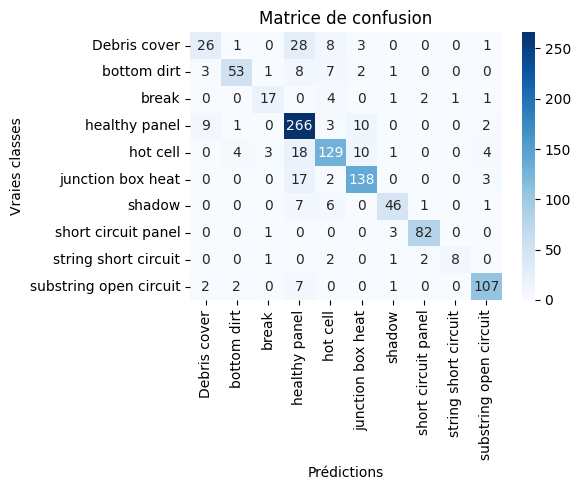

Rapport de classification :
                         precision    recall  f1-score   support

          Debris cover       0.65      0.39      0.49        67
           bottom dirt       0.87      0.71      0.78        75
                 break       0.74      0.65      0.69        26
         healthy panel       0.76      0.91      0.83       291
              hot cell       0.80      0.76      0.78       169
     junction box heat       0.85      0.86      0.85       160
                shadow       0.85      0.75      0.80        61
   short circuit panel       0.94      0.95      0.95        86
  string short circuit       0.89      0.57      0.70        14
substring open circuit       0.90      0.90      0.90       119

              accuracy                           0.82      1068
             macro avg       0.82      0.75      0.78      1068
          weighted avg       0.82      0.82      0.81      1068



🏃 View run overjoyed-bee-200 at: http://mlflow.philippemarechal.org:35000/#/experiments/301285799235823658/runs/dd7a292f05ee4571978cefe6d93c116b
🧪 View experiment at: http://mlflow.philippemarechal.org:35000/#/experiments/301285799235823658

-----------------------------------------------------------------------------------------
Evaluation du meilleur pipeline basé sur DecisionTree pour le split 80.20
-----------------------------------------------------------------------------------------

Temps d'entraînement: 85.94 secondes


Pipeline(steps=[('sampler', 'passthrough'),
                ('features',
                 FeatureUnion(transformer_list=[('stats', BaseStatsExtractor()),
                                                ('histogram', 'drop'),
                                                ('glcm', GLCMExtractor()),
                                                ('edgedensity',
                                                 EdgeDensityExtractor()),
                                                ('entropy', 'drop'),
                                                ('hotspots', 'drop')])),
                ('dropper', VarianceThreshold()), ('scaler', RobustScaler()),
                ('selector', 'passthrough'),
                ('model',
                 DecisionTreeClassifier(max_depth=12, random_state=32))])

Temps de prédiction: 21.46 secondes

-------------------------------------------------------
Résultats obtenus sur le jeu de test du split 80.20 :


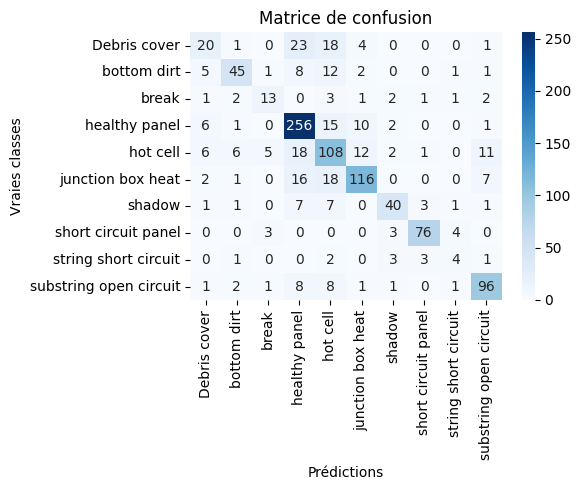

Rapport de classification :
                         precision    recall  f1-score   support

          Debris cover       0.48      0.30      0.37        67
           bottom dirt       0.75      0.60      0.67        75
                 break       0.57      0.50      0.53        26
         healthy panel       0.76      0.88      0.82       291
              hot cell       0.57      0.64      0.60       169
     junction box heat       0.79      0.72      0.76       160
                shadow       0.75      0.66      0.70        61
   short circuit panel       0.90      0.88      0.89        86
  string short circuit       0.33      0.29      0.31        14
substring open circuit       0.79      0.81      0.80       119

              accuracy                           0.72      1068
             macro avg       0.67      0.63      0.64      1068
          weighted avg       0.72      0.72      0.72      1068



🏃 View run bemused-finch-560 at: http://mlflow.philippemarechal.org:35000/#/experiments/301285799235823658/runs/11768f5a870549aa940dfc255d915dbd
🧪 View experiment at: http://mlflow.philippemarechal.org:35000/#/experiments/301285799235823658

-----------------------------------------------------------------------------------------
Evaluation du meilleur pipeline basé sur XGBoost pour le split 80.20
-----------------------------------------------------------------------------------------

Temps d'entraînement: 100.80 secondes


Pipeline(steps=[('sampler', 'passthrough'),
                ('features',
                 FeatureUnion(transformer_list=[('stats', BaseStatsExtractor()),
                                                ('histogram', 'drop'),
                                                ('glcm', GLCMExtractor()),
                                                ('edgedensity',
                                                 EdgeDensityExtractor()),
                                                ('entropy', EntropyExtractor()),
                                                ('hotspots', 'drop')])),
                ('dropper', VarianceThreshold()), ('scaler', 'passthrough'),
                ('selector', 'passthrough'),
                ('model',
                 XG...
       'entropy__hist_bin10', 'entropy__hist_bin11', 'entropy__hist_bin12',
       'entropy__hist_bin13', 'entropy__hist_bin14', 'entropy__hist_bin15',
       'entropy__hist_bin16', 'entropy__hist_bin17', 'entropy__hist_bin18',
       'entropy__hist_bin19', 'entropy__hist_bin20'],
      dtype='object'),
                                                learning_rate=0.3, max_depth=6,
                                                min_child_weight=1,
                                                n_estimators=100,
                                                n_features_in_=76,
                                                random_state=42, subsample=1.0,
                                                tree_method='auto'))])

Temps de prédiction: 25.80 secondes

-------------------------------------------------------
Résultats obtenus sur le jeu de test du split 80.20 :


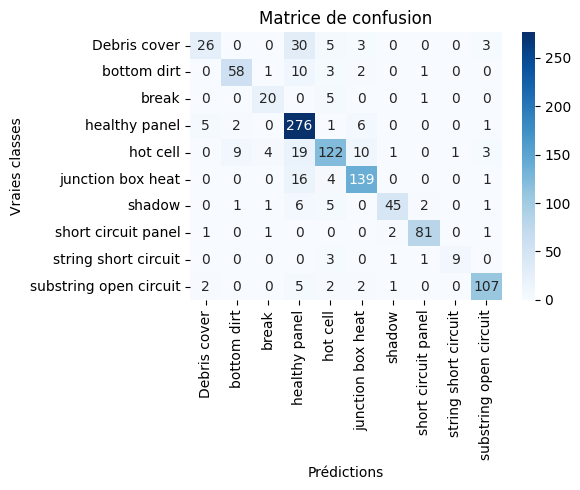

Rapport de classification :
                         precision    recall  f1-score   support

          Debris cover       0.76      0.39      0.51        67
           bottom dirt       0.83      0.77      0.80        75
                 break       0.74      0.77      0.75        26
         healthy panel       0.76      0.95      0.85       291
              hot cell       0.81      0.72      0.76       169
     junction box heat       0.86      0.87      0.86       160
                shadow       0.90      0.74      0.81        61
   short circuit panel       0.94      0.94      0.94        86
  string short circuit       0.90      0.64      0.75        14
substring open circuit       0.91      0.90      0.91       119

              accuracy                           0.83      1068
             macro avg       0.84      0.77      0.80      1068
          weighted avg       0.83      0.83      0.82      1068



🏃 View run rambunctious-ray-589 at: http://mlflow.philippemarechal.org:35000/#/experiments/301285799235823658/runs/f6640745c5d441bba9ffb0a6c00e2bda
🧪 View experiment at: http://mlflow.philippemarechal.org:35000/#/experiments/301285799235823658

-----------------------------------------------------------------------------------------
Evaluation du meilleur pipeline basé sur SVC pour le split 80.20
-----------------------------------------------------------------------------------------

Temps d'entraînement: 98.81 secondes


Pipeline(steps=[('sampler', 'passthrough'),
                ('features',
                 FeatureUnion(transformer_list=[('stats', BaseStatsExtractor()),
                                                ('histogram', 'drop'),
                                                ('glcm', GLCMExtractor()),
                                                ('edgedensity',
                                                 EdgeDensityExtractor()),
                                                ('entropy', EntropyExtractor()),
                                                ('hotspots', 'drop')])),
                ('dropper', VarianceThreshold()), ('scaler', StandardScaler()),
                ('selector',
                 SelectPercentile(percentile=80,
                                  score_func=<function mutual_info_classif at 0x0000024F1F0C40E0>)),
                ('model', SVC(C=10, class_weight='balanced'))])

Temps de prédiction: 24.82 secondes

-------------------------------------------------------
Résultats obtenus sur le jeu de test du split 80.20 :


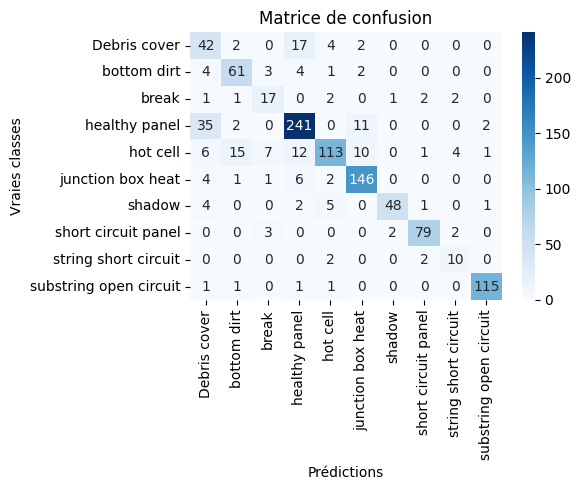

Rapport de classification :
                         precision    recall  f1-score   support

          Debris cover       0.43      0.63      0.51        67
           bottom dirt       0.73      0.81      0.77        75
                 break       0.55      0.65      0.60        26
         healthy panel       0.85      0.83      0.84       291
              hot cell       0.87      0.67      0.76       169
     junction box heat       0.85      0.91      0.88       160
                shadow       0.94      0.79      0.86        61
   short circuit panel       0.93      0.92      0.92        86
  string short circuit       0.56      0.71      0.62        14
substring open circuit       0.97      0.97      0.97       119

              accuracy                           0.82      1068
             macro avg       0.77      0.79      0.77      1068
          weighted avg       0.83      0.82      0.82      1068



🏃 View run nervous-chimp-463 at: http://mlflow.philippemarechal.org:35000/#/experiments/301285799235823658/runs/8733e9542d2244c1a5443a1a21fa0951
🧪 View experiment at: http://mlflow.philippemarechal.org:35000/#/experiments/301285799235823658

-----------------------------------------------------------------------------------------
Evaluation du meilleur pipeline basé sur LightGBM pour le split 80.20
-----------------------------------------------------------------------------------------

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001296 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17576
[LightGBM] [Info] Number of data points in the train set: 4270, nu

Pipeline(steps=[('sampler', 'passthrough'),
                ('features',
                 FeatureUnion(transformer_list=[('stats', BaseStatsExtractor()),
                                                ('histogram', 'drop'),
                                                ('glcm', GLCMExtractor()),
                                                ('edgedensity',
                                                 EdgeDensityExtractor()),
                                                ('entropy', EntropyExtractor()),
                                                ('hotspots', 'drop')])),
                ('dropper', VarianceThreshold()), ('scaler', 'passthrough'),
                ('selector', 'passthrough'),
                ('model',
                 LGBMClassifier(metric='multi_logloss', min_data_in_leaf=20,
                                num_leaves=127, objective='multiclass'))])

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
Temps de prédiction: 24.21 secondes

-------------------------------------------------------
Résultats obtenus sur le jeu de test du split 80.20 :


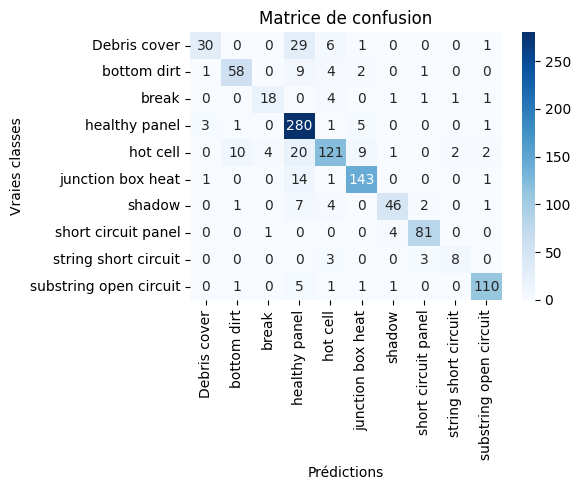

Rapport de classification :
                         precision    recall  f1-score   support

          Debris cover       0.86      0.45      0.59        67
           bottom dirt       0.82      0.77      0.79        75
                 break       0.78      0.69      0.73        26
         healthy panel       0.77      0.96      0.85       291
              hot cell       0.83      0.72      0.77       169
     junction box heat       0.89      0.89      0.89       160
                shadow       0.87      0.75      0.81        61
   short circuit panel       0.92      0.94      0.93        86
  string short circuit       0.73      0.57      0.64        14
substring open circuit       0.94      0.92      0.93       119

              accuracy                           0.84      1068
             macro avg       0.84      0.77      0.79      1068
          weighted avg       0.84      0.84      0.83      1068

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 wi

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
🏃 View run hilarious-calf-735 at: http://mlflow.philippemarechal.org:35000/#/experiments/301285799235823658/runs/31276d47973d4961b42173bff8e00d0e
🧪 View experiment at: http://mlflow.philippemarechal.org:35000/#/experiments/301285799235823658

-----------------------------------------------------------------------------------------
Evaluation du meilleur pipeline basé sur CatBoost pour le split 80.20
-----------------------------------------------------------------------------------------

Learning rate set to 0.085207
0:	learn: 2.0484866	total: 173ms	remaining: 2m 52s
1:	learn: 1.8917040	total: 199ms	remaining: 1m 39s
2:	learn: 1.7650275	total: 226ms	remaining: 1m 15s
3:	learn: 1.6716326	total: 254ms	remaining: 1m 3s
4:	learn: 1.5875917	total: 281ms	remaining: 56s
5:	learn: 1.5173843	total: 310ms	remaining: 51.4s
6:	learn: 1.4497148	total: 339ms	remaining: 48.1s
7:	

Pipeline(steps=[('sampler', 'passthrough'),
                ('features',
                 FeatureUnion(transformer_list=[('stats', BaseStatsExtractor()),
                                                ('histogram', 'drop'),
                                                ('glcm', GLCMExtractor()),
                                                ('edgedensity',
                                                 EdgeDensityExtractor()),
                                                ('entropy', 'drop'),
                                                ('hotspots', 'drop')])),
                ('dropper', VarianceThreshold()), ('scaler', 'passthrough'),
                ('selector',
                 SelectPercentile(percentile=80,
                                  score_func=<function mutual_info_classif at 0x0000024F1F0C40E0>)),
                ('model',
                 <catboost.core.CatBoostClassifier object at 0x0000024F4506A7B0>)])

Temps de prédiction: 20.31 secondes

-------------------------------------------------------
Résultats obtenus sur le jeu de test du split 80.20 :


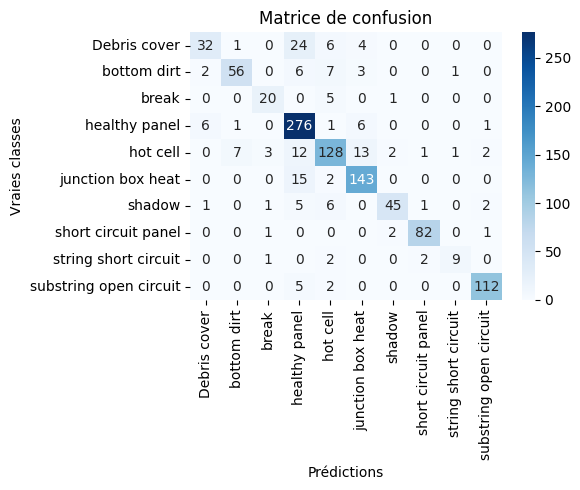

Rapport de classification :
                         precision    recall  f1-score   support

          Debris cover       0.78      0.48      0.59        67
           bottom dirt       0.86      0.75      0.80        75
                 break       0.77      0.77      0.77        26
         healthy panel       0.80      0.95      0.87       291
              hot cell       0.81      0.76      0.78       169
     junction box heat       0.85      0.89      0.87       160
                shadow       0.90      0.74      0.81        61
   short circuit panel       0.95      0.95      0.95        86
  string short circuit       0.82      0.64      0.72        14
substring open circuit       0.95      0.94      0.95       119

              accuracy                           0.85      1068
             macro avg       0.85      0.79      0.81      1068
          weighted avg       0.85      0.85      0.84      1068



🏃 View run capable-doe-863 at: http://mlflow.philippemarechal.org:35000/#/experiments/301285799235823658/runs/60bd9e1d3bbe4c1ba717ffaa193e78a3
🧪 View experiment at: http://mlflow.philippemarechal.org:35000/#/experiments/301285799235823658


In [74]:
best_pipelines_results_80_20 = pd.DataFrame()

get_test_results(best_pipelines, best_pipelines_results_80_20, split_name="80.20")

In [75]:
display(best_pipelines_results_80_20.sort_values("test_f1_macro", ascending=False))

,dataset_split,test_accuracy,test_f1_macro,test_f1_weighted,test_recall_macro,test_recall_weighted,test_precision_macro,test_precision_weighted,train_time,pred_time,n_features_pre_selector,n_features_post_selector
CatBoost,80.20,0.845506,0.811172,0.840889,0.786834,0.845506,0.848793,0.846259,110.025750,20.306180,49.0,39.0
XGBoost,80.20,0.826779,0.795259,0.820579,0.769130,0.826779,0.842420,0.830123,100.799327,25.804162,76.0,76.0
LightGBM,80.20,0.838015,0.794433,0.832293,0.767709,0.838015,0.840439,0.842878,103.077713,24.212001,76.0,76.0
RandomForest,80.20,0.816479,0.776703,0.810963,0.746665,0.816479,0.824611,0.816289,97.673025,24.005553,60.0,60.0
SVC,80.20,0.816479,0.773109,0.820675,0.788953,0.816479,0.768347,0.833173,98.808300,24.822538,76.0,60.0
DecisionTree,80.20,0.724719,0.644257,0.719032,0.627418,0.724719,0.669948,0.721138,85.937442,21.460353,49.0,49.0


In [76]:
# Définition des scores à afficher en fonction du temps
scores = {
    "test_accuracy": "⏱️ Précision vs Temps d'entraînement - Résultats du meilleur pipeline de chaque classifieur sur le jeu de test (split 80/20)",
    "test_f1_macro": "⏱️ F1_macro vs Temps d'entraînement - Résultats du meilleur pipeline de chaque classifieur sur le jeu de test (split 80/20)",
}

display_best_pipelines_graphs(best_pipelines_results_80_20)


# Meilleur pipeline & meilleur classifieur

Sur notre jeu de données, les résultats obtenus à l'aide de ce notebook montrent que le pipeline présentant le meilleur compromis entre les performances et le temps d'aprentissage est basé sur XGBoost, avec les caractéristiques suivantes :

- Augmentation de données : **Non**
- Features :
  - Indicateurs statistiques de base : **Oui**
  - Densité de contours : **Oui**
  - Carte d'entropie : **Oui**
  - Caractéristiques GLCM : **Oui**
  - Histogramme : **Non**
  - Détection HotSpots : **Non**
- Scaling : **Non**
- Sélection de features ou réduction de dimension : **Non**
- Classifieur : **XGBoost**

Cela dit, les résultats obtenus avec les classifieurs suivants sont très proches de ceux obtenus avec ce pipeline :
- **LightGBM** - Le meilleur pipeline basé sur LGBM est même meilleur en accuracy, mais il est un peu plus long en termes de temsp de calcul (apprentissage comme prédiction)
- **CatBoost** - Le meilleur pipeline basé sur CatBoost est meilleur en accuracy comme en f1_score, mais son temps d'entraînement est rédhibitoire.

## Résultats sur le jeu train/test de référence

Afin de comparer les résultats entre les différentes approches et modèles évalués au sein de notre groupe projet, nous avons choisi comme référence de comparaison le split train/test 90/10 tel que défini par les auteurs du dataset.

In [77]:
# raise ValueError("Stop execution!")

In [78]:
# On recharge le dataset pour récupérer les images qu'on avait initialement écartées pour "Doute_Carre"
df_pvf10 = load_dataset(PVF10_CSVFILE, "110x60", False)

# Ensuite on extrait les jeux d'entraînement et de test
df_train = df_pvf10.loc[(df_pvf10['Train_Test'] == 'train')]  
df_test = df_pvf10.loc[(df_pvf10['Train_Test'] == 'test')] 
X_train = df_train.drop('Classe', axis=1)
y_train = df_train['Classe']
X_test = df_test.drop('Classe', axis=1)
y_test = df_test['Classe']

print ("Nb d'images dans l'ensemble d'entraînement :", X_train.shape[0])
print ("Nb d'images dans l'ensemble de test :", X_test.shape[0])

Nb d'images dans l'ensemble d'entraînement : 5019
Nb d'images dans l'ensemble de test : 553



-----------------------------------------------------------------------------------------
Evaluation du meilleur pipeline basé sur RandomForest pour le split 90.10
-----------------------------------------------------------------------------------------

Temps d'entraînement: 102.41 secondes


Pipeline(steps=[('sampler', 'passthrough'),
                ('features',
                 FeatureUnion(transformer_list=[('stats', BaseStatsExtractor()),
                                                ('histogram', 'drop'),
                                                ('glcm', GLCMExtractor()),
                                                ('edgedensity',
                                                 EdgeDensityExtractor()),
                                                ('entropy', 'drop'),
                                                ('hotspots',
                                                 HotSpotsExtractor())])),
                ('dropper', VarianceThreshold()), ('scaler', MinMaxScaler()),
                ('selector', 'passthrough'),
                ('model',
                 RandomForestClassifier(class_weight='balanced', max_depth=17,
                                        min_samples_leaf=2, n_estimators=95,
                                        random_state=42))])

Temps de prédiction: 10.84 secondes

-------------------------------------------------------
Résultats obtenus sur le jeu de test du split 90.10 :


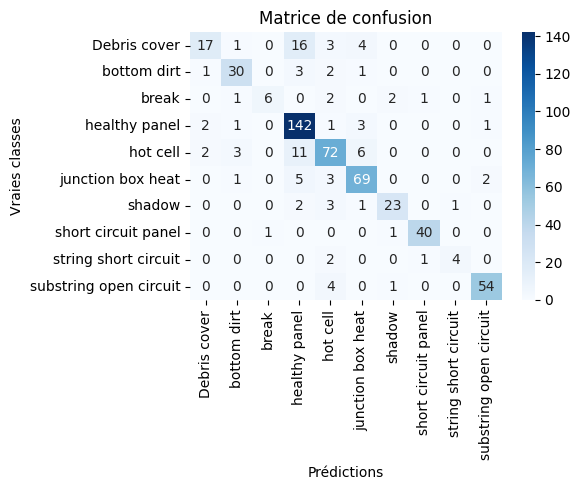

Rapport de classification :
                         precision    recall  f1-score   support

          Debris cover       0.77      0.41      0.54        41
           bottom dirt       0.81      0.81      0.81        37
                 break       0.86      0.46      0.60        13
         healthy panel       0.79      0.95      0.86       150
              hot cell       0.78      0.77      0.77        94
     junction box heat       0.82      0.86      0.84        80
                shadow       0.85      0.77      0.81        30
   short circuit panel       0.95      0.95      0.95        42
  string short circuit       0.80      0.57      0.67         7
substring open circuit       0.93      0.92      0.92        59

              accuracy                           0.83       553
             macro avg       0.84      0.75      0.78       553
          weighted avg       0.83      0.83      0.82       553



🏃 View run gifted-shad-249 at: http://mlflow.philippemarechal.org:35000/#/experiments/971923166830133317/runs/f2b9f1cdf552485492effeff67b12905
🧪 View experiment at: http://mlflow.philippemarechal.org:35000/#/experiments/971923166830133317

-----------------------------------------------------------------------------------------
Evaluation du meilleur pipeline basé sur DecisionTree pour le split 90.10
-----------------------------------------------------------------------------------------

Temps d'entraînement: 96.60 secondes


Pipeline(steps=[('sampler', 'passthrough'),
                ('features',
                 FeatureUnion(transformer_list=[('stats', BaseStatsExtractor()),
                                                ('histogram', 'drop'),
                                                ('glcm', GLCMExtractor()),
                                                ('edgedensity',
                                                 EdgeDensityExtractor()),
                                                ('entropy', 'drop'),
                                                ('hotspots', 'drop')])),
                ('dropper', VarianceThreshold()), ('scaler', RobustScaler()),
                ('selector', 'passthrough'),
                ('model',
                 DecisionTreeClassifier(max_depth=12, random_state=32))])

Temps de prédiction: 10.62 secondes

-------------------------------------------------------
Résultats obtenus sur le jeu de test du split 90.10 :


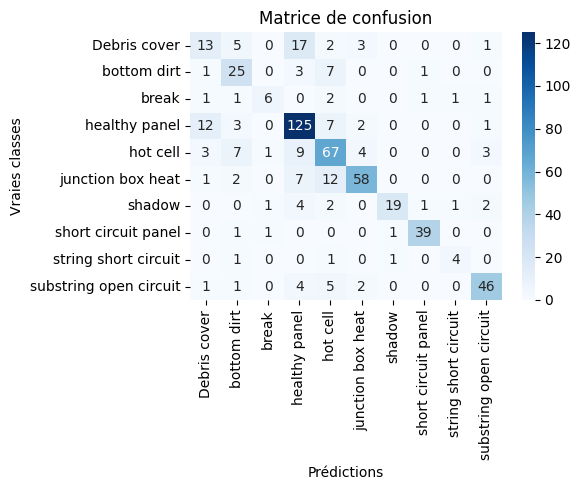

Rapport de classification :
                         precision    recall  f1-score   support

          Debris cover       0.41      0.32      0.36        41
           bottom dirt       0.54      0.68      0.60        37
                 break       0.67      0.46      0.55        13
         healthy panel       0.74      0.83      0.78       150
              hot cell       0.64      0.71      0.67        94
     junction box heat       0.84      0.72      0.78        80
                shadow       0.90      0.63      0.75        30
   short circuit panel       0.93      0.93      0.93        42
  string short circuit       0.67      0.57      0.62         7
substring open circuit       0.85      0.78      0.81        59

              accuracy                           0.73       553
             macro avg       0.72      0.66      0.68       553
          weighted avg       0.73      0.73      0.72       553



🏃 View run handsome-shark-349 at: http://mlflow.philippemarechal.org:35000/#/experiments/971923166830133317/runs/7a8d3abd21b54f5cbfe0a3b0c716c79c
🧪 View experiment at: http://mlflow.philippemarechal.org:35000/#/experiments/971923166830133317

-----------------------------------------------------------------------------------------
Evaluation du meilleur pipeline basé sur XGBoost pour le split 90.10
-----------------------------------------------------------------------------------------

Temps d'entraînement: 117.17 secondes


Pipeline(steps=[('sampler', 'passthrough'),
                ('features',
                 FeatureUnion(transformer_list=[('stats', BaseStatsExtractor()),
                                                ('histogram', 'drop'),
                                                ('glcm', GLCMExtractor()),
                                                ('edgedensity',
                                                 EdgeDensityExtractor()),
                                                ('entropy', EntropyExtractor()),
                                                ('hotspots', 'drop')])),
                ('dropper', VarianceThreshold()), ('scaler', 'passthrough'),
                ('selector', 'passthrough'),
                ('model',
                 XG...
       'entropy__hist_bin10', 'entropy__hist_bin11', 'entropy__hist_bin12',
       'entropy__hist_bin13', 'entropy__hist_bin14', 'entropy__hist_bin15',
       'entropy__hist_bin16', 'entropy__hist_bin17', 'entropy__hist_bin18',
       'entropy__hist_bin19', 'entropy__hist_bin20'],
      dtype='object'),
                                                learning_rate=0.3, max_depth=6,
                                                min_child_weight=1,
                                                n_estimators=100,
                                                n_features_in_=76,
                                                random_state=42, subsample=1.0,
                                                tree_method='auto'))])

Temps de prédiction: 12.60 secondes

-------------------------------------------------------
Résultats obtenus sur le jeu de test du split 90.10 :


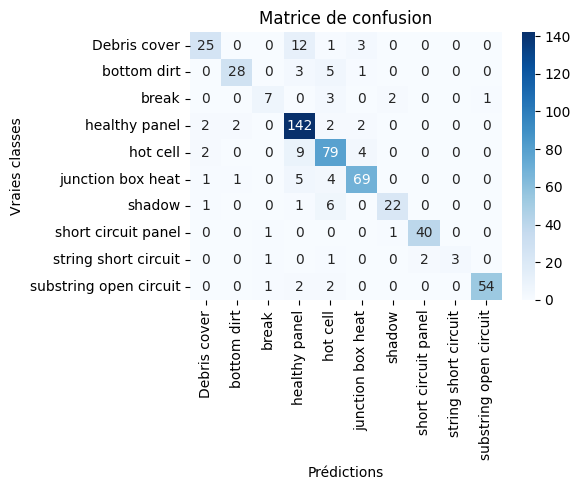

Rapport de classification :
                         precision    recall  f1-score   support

          Debris cover       0.81      0.61      0.69        41
           bottom dirt       0.90      0.76      0.82        37
                 break       0.70      0.54      0.61        13
         healthy panel       0.82      0.95      0.88       150
              hot cell       0.77      0.84      0.80        94
     junction box heat       0.87      0.86      0.87        80
                shadow       0.88      0.73      0.80        30
   short circuit panel       0.95      0.95      0.95        42
  string short circuit       1.00      0.43      0.60         7
substring open circuit       0.98      0.92      0.95        59

              accuracy                           0.85       553
             macro avg       0.87      0.76      0.80       553
          weighted avg       0.85      0.85      0.84       553



🏃 View run nimble-owl-993 at: http://mlflow.philippemarechal.org:35000/#/experiments/971923166830133317/runs/d55331ee42bd4374b806cc3e1fc725d7
🧪 View experiment at: http://mlflow.philippemarechal.org:35000/#/experiments/971923166830133317

-----------------------------------------------------------------------------------------
Evaluation du meilleur pipeline basé sur SVC pour le split 90.10
-----------------------------------------------------------------------------------------

Temps d'entraînement: 116.64 secondes


Pipeline(steps=[('sampler', 'passthrough'),
                ('features',
                 FeatureUnion(transformer_list=[('stats', BaseStatsExtractor()),
                                                ('histogram', 'drop'),
                                                ('glcm', GLCMExtractor()),
                                                ('edgedensity',
                                                 EdgeDensityExtractor()),
                                                ('entropy', EntropyExtractor()),
                                                ('hotspots', 'drop')])),
                ('dropper', VarianceThreshold()), ('scaler', StandardScaler()),
                ('selector',
                 SelectPercentile(percentile=80,
                                  score_func=<function mutual_info_classif at 0x0000024F1F0C40E0>)),
                ('model', SVC(C=10, class_weight='balanced'))])

Temps de prédiction: 12.69 secondes

-------------------------------------------------------
Résultats obtenus sur le jeu de test du split 90.10 :


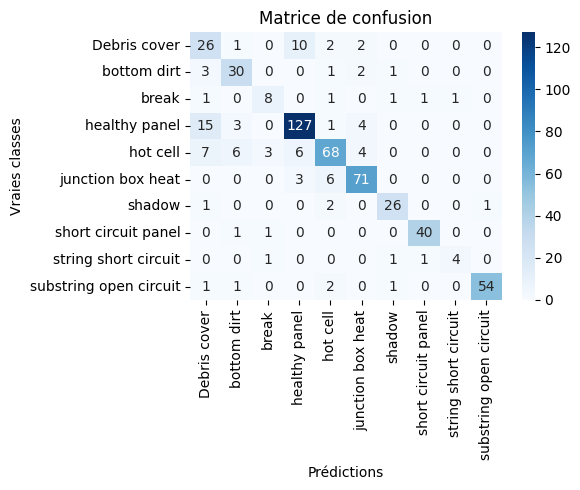

Rapport de classification :
                         precision    recall  f1-score   support

          Debris cover       0.48      0.63      0.55        41
           bottom dirt       0.71      0.81      0.76        37
                 break       0.62      0.62      0.62        13
         healthy panel       0.87      0.85      0.86       150
              hot cell       0.82      0.72      0.77        94
     junction box heat       0.86      0.89      0.87        80
                shadow       0.87      0.87      0.87        30
   short circuit panel       0.95      0.95      0.95        42
  string short circuit       0.80      0.57      0.67         7
substring open circuit       0.98      0.92      0.95        59

              accuracy                           0.82       553
             macro avg       0.80      0.78      0.79       553
          weighted avg       0.83      0.82      0.82       553



🏃 View run honorable-lynx-256 at: http://mlflow.philippemarechal.org:35000/#/experiments/971923166830133317/runs/7b0efe59d8544098a1312819847edc1b
🧪 View experiment at: http://mlflow.philippemarechal.org:35000/#/experiments/971923166830133317

-----------------------------------------------------------------------------------------
Evaluation du meilleur pipeline basé sur LightGBM pour le split 90.10
-----------------------------------------------------------------------------------------

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17643
[LightGBM] [Info] Number of data points in the train set: 5019, n

Pipeline(steps=[('sampler', 'passthrough'),
                ('features',
                 FeatureUnion(transformer_list=[('stats', BaseStatsExtractor()),
                                                ('histogram', 'drop'),
                                                ('glcm', GLCMExtractor()),
                                                ('edgedensity',
                                                 EdgeDensityExtractor()),
                                                ('entropy', EntropyExtractor()),
                                                ('hotspots', 'drop')])),
                ('dropper', VarianceThreshold()), ('scaler', 'passthrough'),
                ('selector', 'passthrough'),
                ('model',
                 LGBMClassifier(metric='multi_logloss', min_data_in_leaf=20,
                                num_leaves=127, objective='multiclass'))])

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
Temps de prédiction: 12.74 secondes

-------------------------------------------------------
Résultats obtenus sur le jeu de test du split 90.10 :


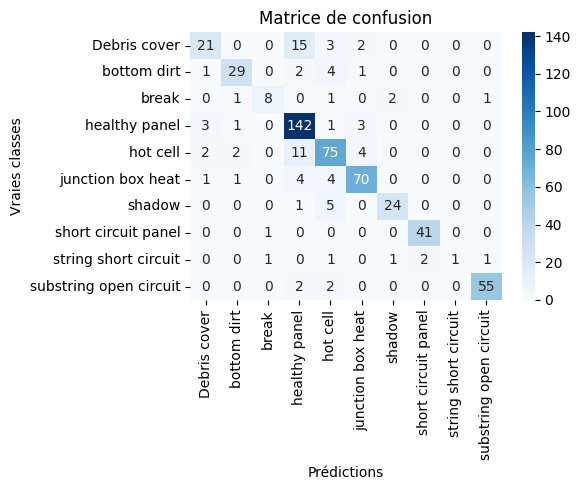

Rapport de classification :
                         precision    recall  f1-score   support

          Debris cover       0.75      0.51      0.61        41
           bottom dirt       0.85      0.78      0.82        37
                 break       0.80      0.62      0.70        13
         healthy panel       0.80      0.95      0.87       150
              hot cell       0.78      0.80      0.79        94
     junction box heat       0.88      0.88      0.88        80
                shadow       0.89      0.80      0.84        30
   short circuit panel       0.95      0.98      0.96        42
  string short circuit       1.00      0.14      0.25         7
substring open circuit       0.96      0.93      0.95        59

              accuracy                           0.84       553
             macro avg       0.87      0.74      0.77       553
          weighted avg       0.84      0.84      0.84       553

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 wi

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
🏃 View run casual-worm-183 at: http://mlflow.philippemarechal.org:35000/#/experiments/971923166830133317/runs/2f49f44ac4e64a40b07f879fc877a33b
🧪 View experiment at: http://mlflow.philippemarechal.org:35000/#/experiments/971923166830133317

-----------------------------------------------------------------------------------------
Evaluation du meilleur pipeline basé sur CatBoost pour le split 90.10
-----------------------------------------------------------------------------------------

Learning rate set to 0.085912
0:	learn: 2.0573397	total: 27.8ms	remaining: 27.7s
1:	learn: 1.9061264	total: 54.7ms	remaining: 27.3s
2:	learn: 1.7865352	total: 84.8ms	remaining: 28.2s
3:	learn: 1.6889425	total: 112ms	remaining: 28s
4:	learn: 1.6021408	total: 140ms	remaining: 27.9s
5:	learn: 1.5348717	total: 170ms	remaining: 28.1s
6:	learn: 1.4728564	total: 196ms	remaining: 27.8s
7:	lea

Pipeline(steps=[('sampler', 'passthrough'),
                ('features',
                 FeatureUnion(transformer_list=[('stats', BaseStatsExtractor()),
                                                ('histogram', 'drop'),
                                                ('glcm', GLCMExtractor()),
                                                ('edgedensity',
                                                 EdgeDensityExtractor()),
                                                ('entropy', 'drop'),
                                                ('hotspots', 'drop')])),
                ('dropper', VarianceThreshold()), ('scaler', 'passthrough'),
                ('selector',
                 SelectPercentile(percentile=80,
                                  score_func=<function mutual_info_classif at 0x0000024F1F0C40E0>)),
                ('model',
                 <catboost.core.CatBoostClassifier object at 0x0000024F3A610470>)])

Temps de prédiction: 10.67 secondes

-------------------------------------------------------
Résultats obtenus sur le jeu de test du split 90.10 :


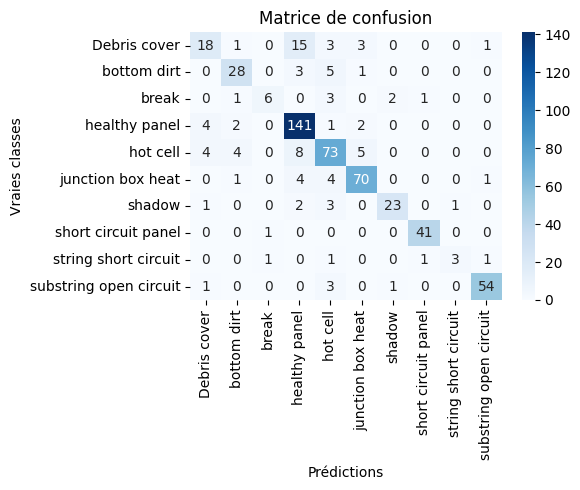

Rapport de classification :
                         precision    recall  f1-score   support

          Debris cover       0.64      0.44      0.52        41
           bottom dirt       0.76      0.76      0.76        37
                 break       0.75      0.46      0.57        13
         healthy panel       0.82      0.94      0.87       150
              hot cell       0.76      0.78      0.77        94
     junction box heat       0.86      0.88      0.87        80
                shadow       0.88      0.77      0.82        30
   short circuit panel       0.95      0.98      0.96        42
  string short circuit       0.75      0.43      0.55         7
substring open circuit       0.95      0.92      0.93        59

              accuracy                           0.83       553
             macro avg       0.81      0.73      0.76       553
          weighted avg       0.82      0.83      0.82       553



🏃 View run nervous-deer-380 at: http://mlflow.philippemarechal.org:35000/#/experiments/971923166830133317/runs/7dd93cc7298b4b519577d21ba177cb11
🧪 View experiment at: http://mlflow.philippemarechal.org:35000/#/experiments/971923166830133317


In [79]:
best_pipelines_results_90_10 = pd.DataFrame()

get_test_results(best_pipelines, best_pipelines_results_90_10, split_name="90.10")

In [80]:
display(best_pipelines_results_90_10.sort_values("test_f1_macro", ascending=False))

,dataset_split,test_accuracy,test_f1_macro,test_f1_weighted,test_recall_macro,test_recall_weighted,test_precision_macro,test_precision_weighted,train_time,pred_time,n_features_pre_selector,n_features_post_selector
XGBoost,90.10,0.848101,0.797292,0.844949,0.758411,0.848101,0.868038,0.852252,117.173627,12.602732,76.0,76.0
SVC,90.10,0.820976,0.785296,0.824123,0.782364,0.820976,0.795658,0.831143,116.641927,12.692204,76.0,60.0
RandomForest,90.10,0.826401,0.777851,0.818879,0.746784,0.826401,0.837328,0.826736,102.413280,10.843204,60.0,60.0
LightGBM,90.10,0.842676,0.765931,0.835787,0.738215,0.842676,0.866874,0.844717,118.628946,12.744427,76.0,76.0
CatBoost,90.10,0.826401,0.762360,0.820047,0.733560,0.826401,0.812473,0.822253,125.346563,10.674178,49.0,39.0
DecisionTree,90.10,0.726944,0.684283,0.724796,0.663838,0.726944,0.718657,0.731780,96.599200,10.620703,49.0,49.0


In [81]:
# Définition des scores à afficher en fonction du temps
scores = {
    "test_accuracy": "⏱️ Précision vs Temps d'entraînement - Résultats du meilleur pipeline de chaque classifieur sur le jeu de test (split 90/10)",
    "test_f1_macro": "⏱️ F1_macro vs Temps d'entraînement - Résultats du meilleur pipeline de chaque classifieur sur le jeu de test (split 90/10)",
}

display_best_pipelines_graphs(best_pipelines_results_90_10)

# Conclusions intermédiaires

## Influence de l'augmentation de données

Il apparaît que la technique d'augmentation de données choisie n'apporte pas d'amélioration.

Il aurait pu être utile de la comparer aux techniques "classiques" d'oversampling telles que SMOTE ou ADASYN, mais cela n'a pas été expérimenté.

## Features pertinents

En compléments des indicateurs statistiques basiques, il apparaît que les features les plus pertinents sont les suivants :
1. **GLCM (Gray-Level Co-occurence Matrix)** : les caractéristiques statistiques extraites de la matrice GLCM, qui représente la fréquence d'apparition de paires de pixels ayant des valeurs de gris spécifiques, à une certaine distance et direction l’un par rapport à l’autre. C'est d'une certaine façon une analyse de la texture d'une image.
   - Les features GLCM sont utiles pour tous les classifieurs
2. **EdgeDensity** : la densité de contours. Bien que l'extraction de cette information ne produise qu'une seule donnée dans l'ensemble des features, elle semble très pertinente.
   - L'information EdgeDensity est utile pour tous les classifieurs
3. **Entropy** : les caractéristiques d'entropie de l'image. C'est une analyse de la complexité de l'image.
   - Les caractéristiques Entropy sont utiles pour certains classifieurs, mais pas tous
4. **HotSpots** : ces informations permettent de caractériser les points chauds de l'image (nombre, moyenne et écart-type des surfaces, moyenne et écart-type des valeurs, etc.)
   - Les informations HotSpots sont rarement utiles (utilisées par un seul classifieur : RandomForest). L'extraction de ces informations a été ajouté au cours de la phase de modélisation. C'est une approche particulièrement liée au domaine "métier" de notre problème : il pourrait être utile de travailler cette approche utilisant les points chauds pour améliorer sa pertinence.

L'**histogramme** de l'image, quant à lui, ne s'est jamais avéré pertinent. Il a été calculé sur les 255 valeurs possibles des pixels de l'image, sans regroupement des valeurs (de 10 en 10 par exemple). Il est possible que l'information qu'il contient 


## Utilité de la réduction de dimensions

La réduction de dimension de type PCA ou UMAP ne s'est jamais révélée utile : au contraire, à pipelines identiques "tous paramètres égaux par ailleurs", les résultats obtenus apparaissent moins bons entre un pipeline qui n'utilise aucune réduction et un pipeline qui utilise une PCA (quelle que soit la cible sur le taux de variance expliquée) ou une UMAP (quel que soit le nombre de composantes cible).

La sélection du nombre de features par un algorithme SelectPercentiles'est avérée utile pour 2 classifieurs : SVC et CatBoost.

# Interprétabilité

On va étudier l'interprétabilité du pipeline basé sur XGBoost.

In [82]:
# On reprend notre pipeline avec les paramètres optimisés
xgboost_best_pipeline_params = deepcopy(best_pipelines["XGBoost"])
interp_pipeline = pipe.set_params(**xgboost_best_pipeline_params)

# Découpage train / test par défaut
df_pvf10 = load_dataset(PVF10_CSVFILE, "110x60", True)
splits = improved_train_test_validation_split(df_pvf10, 
                                              target_col="Classe", 
                                              train_size=TRAIN_SIZE,
                                              validation_size=VALIDATION_SIZE, 
                                              test_size=TEST_SIZE, 
                                              random_state=RANDOM_STATE,
                                              stratify=True,
                                              )
if len(splits) == 6:
    X_train, X_test, X_validation, y_train, y_test, y_validation = splits
else:
    X_train, X_test, y_train, y_test = splits

print ("Nb d'images dans l'ensemble d'entraînement :", X_train.shape[0])
print ("Nb d'images dans l'ensemble de test :", X_test.shape[0])

# Entraînement et prédiction
interp_pipeline.fit(X_train, y_train)
y_pred = interp_pipeline.predict(X_test)
y_pred_proba = interp_pipeline.predict_proba(X_test)

# On récupère l'ensemble train après l'extraction des features
start_pipe = interp_pipeline[1]
X_train_transformed = start_pipe.transform(X_train)
# X_train_transformed = pd.DataFrame(X_train_transformed, index=X_train.index, columns=start_pipe.get_feature_names_out())
display(X_train_transformed)

# On récupère l'ensemble test après l'extraction des features
X_test_transformed = start_pipe.transform(X_test)
display(X_test_transformed)

# On récupère le classifieur XGBoost (étape finale de la pipeline)
xgbc = interp_pipeline[-1]


Nb d'images dans l'ensemble d'entraînement : 4270
Nb d'images dans l'ensemble de test : 1068


,stats__mean,stats__median,stats__max,stats__std,stats__min,stats__ptp,stats__skewness,stats__kurtosis,stats__iqr_25_75,stats__p_0.05,...,entropy__hist_bin11,entropy__hist_bin12,entropy__hist_bin13,entropy__hist_bin14,entropy__hist_bin15,entropy__hist_bin16,entropy__hist_bin17,entropy__hist_bin18,entropy__hist_bin19,entropy__hist_bin20
3340,119.155758,106.0,247,45.149271,6,241,1.020652,0.319916,54.00,69.0,...,0.353666,0.205247,0.257663,0.235041,0.259870,0.397805,0.552844,0.562775,0.368563,0.118624
3459,97.839697,75.0,247,50.188083,30,217,1.486110,1.190346,49.00,53.0,...,0.176690,0.108732,0.124498,0.141895,0.165273,0.269112,0.364796,0.468091,0.396328,0.115800
2826,121.586667,126.0,243,22.279745,14,229,0.491947,5.730986,18.00,84.0,...,0.264039,0.236801,0.322961,0.398004,0.362428,0.281271,0.186773,0.109507,0.061146,0.022791
3721,121.200909,126.0,184,23.563594,39,145,-0.585524,-0.241530,35.00,78.0,...,0.233713,0.290009,0.345167,0.403737,0.497564,0.525996,0.471406,0.322421,0.138181,0.021040
3543,153.022879,144.0,236,28.191352,118,118,1.040039,0.368449,38.00,122.0,...,0.107839,0.148974,0.242916,0.300171,0.470267,0.478050,0.524187,0.579774,0.440250,0.081713
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3023,143.423788,141.0,243,25.648550,57,186,1.504262,5.351829,14.00,115.0,...,0.414496,0.406940,0.340016,0.229916,0.196993,0.168929,0.167849,0.204010,0.122514,0.016731
5002,116.303182,118.0,136,8.496687,48,88,-1.627892,6.123516,12.00,101.0,...,0.464715,0.392829,0.400817,0.466893,0.454549,0.344906,0.179351,0.115453,0.055185,0.015975
3841,165.331061,158.0,234,33.659209,68,166,0.422820,-0.536557,47.25,118.0,...,0.281607,0.435628,0.493674,0.584478,0.490800,0.431605,0.239653,0.204021,0.195401,0.068965
2222,155.751061,158.0,227,12.852343,56,171,-0.374649,10.159419,13.00,135.0,...,0.428666,0.538595,0.512422,0.406564,0.302451,0.252430,0.218114,0.083174,0.034317,0.013959


,stats__mean,stats__median,stats__max,stats__std,stats__min,stats__ptp,stats__skewness,stats__kurtosis,stats__iqr_25_75,stats__p_0.05,...,entropy__hist_bin11,entropy__hist_bin12,entropy__hist_bin13,entropy__hist_bin14,entropy__hist_bin15,entropy__hist_bin16,entropy__hist_bin17,entropy__hist_bin18,entropy__hist_bin19,entropy__hist_bin20
3354,115.591667,103.0,244,39.901209,43,201,1.588119,1.914596,33.00,74.0,...,0.297394,0.328758,0.232987,0.287873,0.326518,0.278352,0.355081,0.399326,0.306916,0.078409
3348,141.759848,146.0,247,41.136805,40,207,0.384526,-0.353245,57.00,84.0,...,0.229067,0.375243,0.413328,0.309156,0.294594,0.376364,0.431810,0.468774,0.464294,0.129375
2923,167.484242,171.0,228,17.030527,68,160,-1.562006,5.636734,16.00,137.0,...,0.403596,0.464078,0.474818,0.392856,0.310328,0.283195,0.288283,0.198971,0.064440,0.029394
1031,160.180303,161.0,192,7.851418,82,110,-1.687564,8.894788,8.00,146.0,...,0.402126,0.459948,0.456662,0.473746,0.418552,0.321963,0.259542,0.130099,0.092647,0.037453
3274,163.100152,151.0,247,27.869139,40,207,1.421664,1.277697,22.00,140.0,...,0.230187,0.203864,0.213385,0.277232,0.265471,0.259310,0.304115,0.458133,0.443011,0.077849
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5140,149.782273,151.0,167,5.606627,113,54,-1.005243,1.909963,6.00,139.0,...,0.376027,0.401047,0.426783,0.488977,0.404622,0.296675,0.226617,0.135112,0.030740,0.007864
3368,116.726515,104.0,244,36.910640,9,235,1.825751,3.068350,21.00,87.0,...,0.168281,0.220144,0.231179,0.246628,0.268698,0.356976,0.380149,0.347045,0.313940,0.080554
1257,48.543636,49.0,99,5.948127,11,88,-1.630342,8.641613,6.00,40.0,...,0.587274,0.514588,0.388514,0.265656,0.157593,0.111923,0.134436,0.086837,0.057248,0.007719
5084,135.465152,138.0,152,10.501053,53,99,-2.597120,9.734766,8.00,114.0,...,0.397953,0.405333,0.348132,0.276783,0.185137,0.151308,0.204204,0.234958,0.183292,0.048591


### Interprétabilité spécifique

Le classifieur **XGBoost** permet une **interprétabilité spécifique**. Afin de mieux comprendre l'**importance des features**, nous pouvons les regrouper par catégorie :
- **stats** : indicateurs statistiques "basiques"
- **stats__p_** : les 19 percentiles, de 5% à 95% par pas de 5%
- **glcm__*propriété*** : les 5 propriétés GLCM **contrast**, **dissimilarity**, **homogeneity**, **energy** & **correlation**
- **edgedensity** : la densité de contours
- **entropy** : les indicateurs statistiques de la carte d'entropie
- **entropy__hist** : l'histogramme des valeurs d'entropie

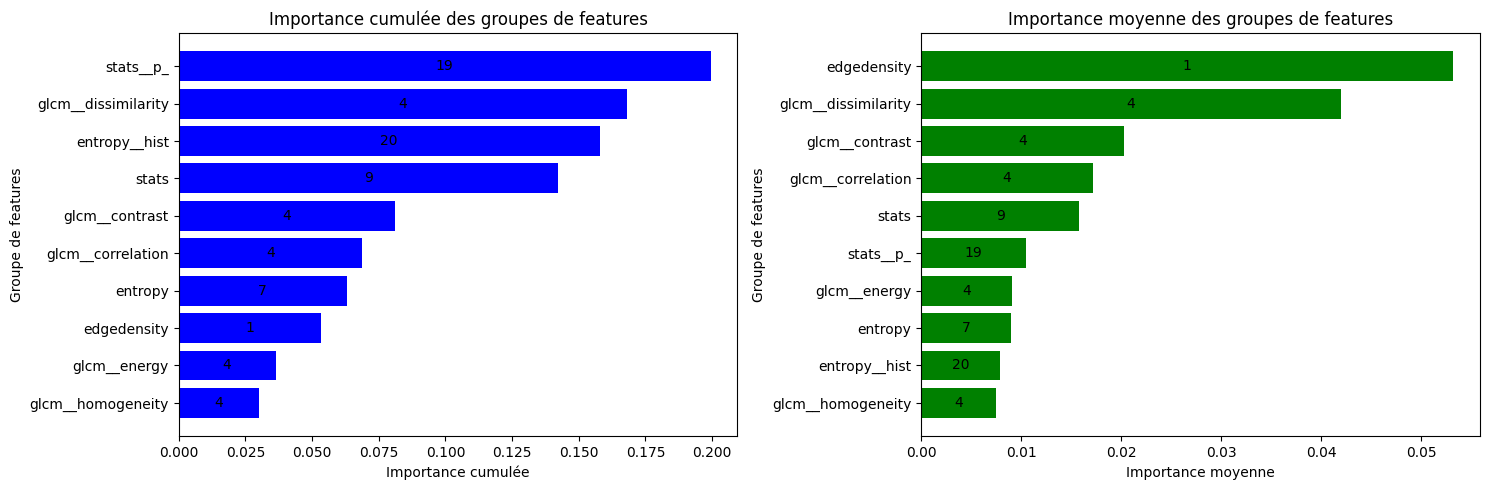

In [83]:
# Récupération de l'importance des features utilisées par Random Forest
importances = xgbc.feature_importances_

# Regroupement des features par catégorie 
feature_groups = X_test_transformed.columns.str.extract(
        r'^(stats__p_|stats|glcm__contrast|glcm__dissimilarity|glcm__homogeneity|glcm__energy|glcm__correlation|edgedensity|entropy__hist|entropy)',
        expand=False)
importances_df = pd.DataFrame({
    "feature": X_test_transformed.columns,
    "importance": importances,
    "groupe": feature_groups
})

# Importance cumulée par catégorie
group_importance = importances_df.groupby("groupe")["importance"].agg({"sum", "count"}).sort_values("sum")

# Importance moyenne par catégorie
group_mean = importances_df.groupby("groupe")["importance"].agg({"mean", "count"}).sort_values("mean")

# Affichage sur 2 graphes
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(15,5))

p = axs[0].barh(group_importance.index, group_importance["sum"], color="blue")
axs[0].bar_label(p, labels=group_importance["count"], label_type='center')
axs[0].set_title("Importance cumulée des groupes de features")
axs[0].set_xlabel("Importance cumulée")
axs[0].set_ylabel("Groupe de features")

p = axs[1].barh(group_mean.index, group_mean["mean"], color="green")
axs[1].bar_label(p, labels=group_mean["count"], label_type='center')
axs[1].set_title("Importance moyenne des groupes de features")
axs[1].set_xlabel("Importance moyenne")
axs[1].set_ylabel("Groupe de features")

plt.tight_layout()
plt.show()

**Constatations** :

A écrire...

Nous pouvons aussi inspecter les importances individuelles, par groupe de features.

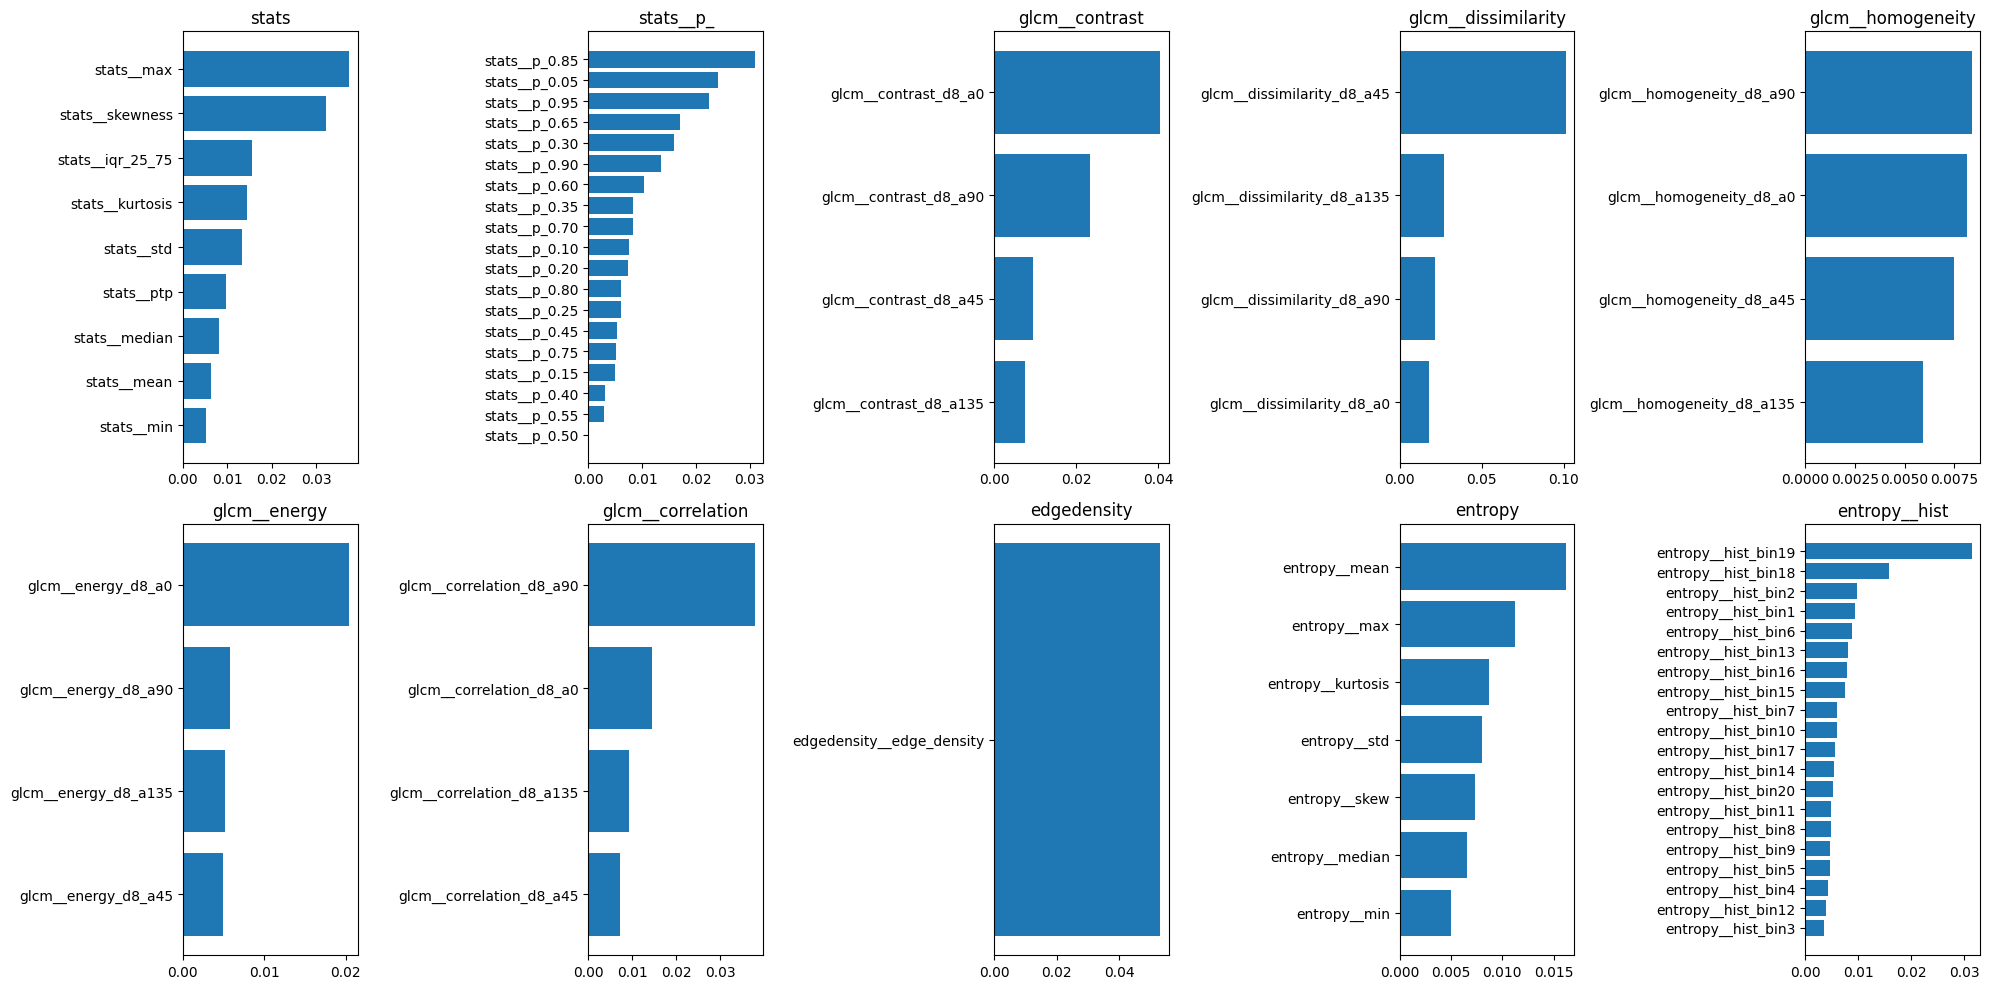

In [84]:
# Initialisation de la figure
fig,axes = plt.subplots(2, 5, figsize=(20,10))

# Pour chaque groupe de features
for i, group in enumerate(importances_df['groupe'].unique()):
    
    # Création du barplot

    current_importances_df = importances_df[importances_df["groupe"] == group].sort_values("importance")

    plt.subplot(2, 5, i+1)
    plt.barh(current_importances_df["feature"], current_importances_df["importance"])
    plt.title(group)

plt.tight_layout()
plt.show()

**Constatations** :

A écrire...

### Interprétabilité SHAP globale

Nous allons maintenant utiliser le modèle d'interprétabilité **SHAP Tree Explainer** qui est adapté à un classifieur basé sur XGBoost. On commence par l'interprétabilité globale sur l'ensemble des classes.

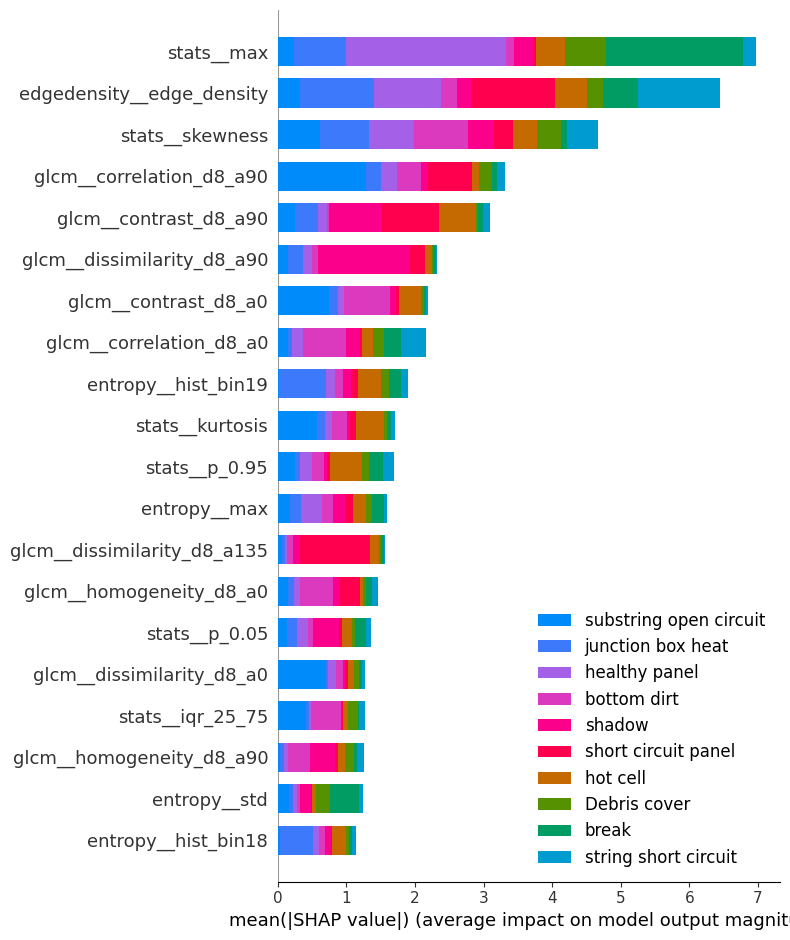

In [85]:
# Interprétabilité GLOBALE avec SHAP TreeExplainer
import shap

# Créer un explainer SHAP pour le modèle XGBoost
explainer = shap.TreeExplainer(xgbc.clf)

# Calculer les shap-values pour le jeu de test (après extraction des features)
shap_values = explainer.shap_values(X_test_transformed)

# Afficher l'interprétation globale
shap.summary_plot(shap_values, X_test_transformed, plot_type='bar', class_names=xgbc.classes_)

### Interprétabilité SHAP locale

**On commence par interpréter une image sur laquelle le modèle a vu juste**

Réel : short circuit panel
Prédit : short circuit panel


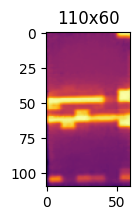

In [86]:
# On choisit une instance de test à expliquer
instance_idx = 800
module = PVModule.get_module(X_test.iloc[instance_idx]["Chemin"])
print(f"Réel : {module.status}")
print(f"Prédit : {y_pred[instance_idx]}")
module.plot(display_colorbar=False)

actual_class = module.status

In [87]:
predicted_class_idx = xgbc.classes_.tolist().index(actual_class)
print (f"Probabilité prédiction classe '{actual_class}' : {y_pred_proba[instance_idx][predicted_class_idx]}")

Probabilité prédiction classe 'short circuit panel' : 0.9996976852416992


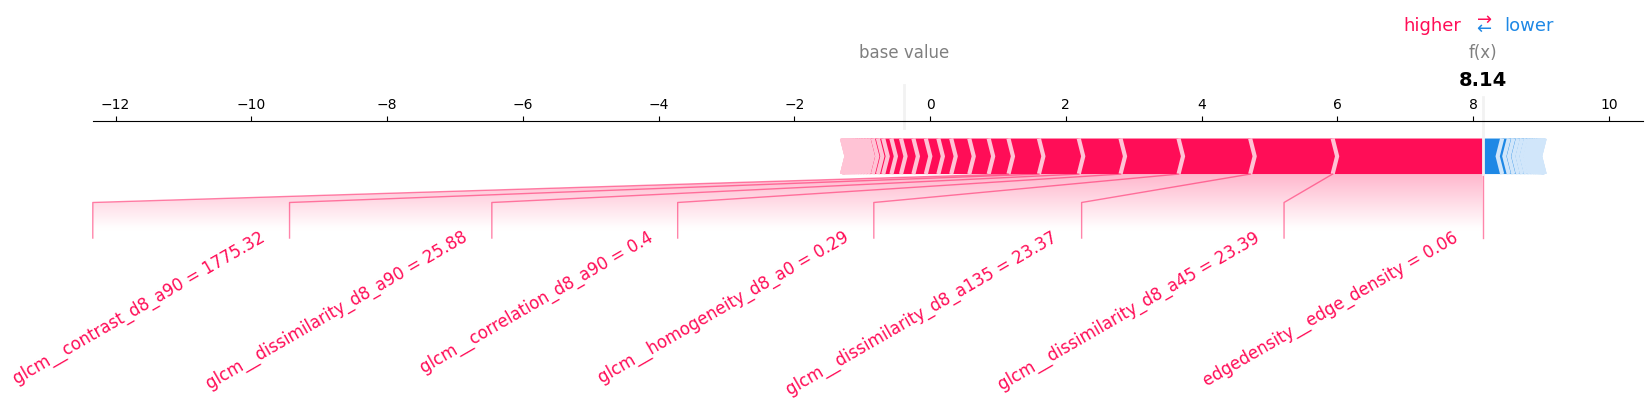

In [88]:
# Force-plot SHAP sur la classe prédite
shap.force_plot(
    explainer.expected_value[predicted_class_idx], 
    shap_values[instance_idx,:,predicted_class_idx], 
    np.round(X_test_transformed.iloc[instance_idx].values,2), # On arrondit les valeurs pour la présentation du graphique
    feature_names = X_test_transformed.columns,
    contribution_threshold = 0.05, # On n'affiche que les features les + importantes
    text_rotation=30,
    matplotlib=True,
)

On constate sur cette image que le très fort contraste et la densité de contours élevée (8%) ont contribué au classement de cette image en short circuit panel. Ce type de défauts entraîne effectivement de brusques variations de température sur le panneau.

**On observe maintenant une image sur laquelle le modèle s'est trompé**

Réel : substring open circuit
Prédit : junction box heat


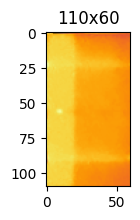

In [89]:
# On choisit une instance de test à expliquer
instance_idx = 801
module = PVModule.get_module(X_test.iloc[instance_idx]["Chemin"])
print(f"Réel : {module.status}")
print(f"Prédit : {y_pred[instance_idx]}")
module.plot(display_colorbar=False)

actual_class = module.status
predicted_class = y_pred[instance_idx]

In [90]:
actual_class_idx = xgbc.classes_.tolist().index(actual_class)
print (f"Probabilité prédiction classe '{actual_class}' (réel) : {y_pred_proba[instance_idx][actual_class_idx]}")
predicted_class_idx = xgbc.classes_.tolist().index(predicted_class)
print (f"Probabilité prédiction classe '{predicted_class}' : {y_pred_proba[instance_idx][predicted_class_idx]}")

Probabilité prédiction classe 'substring open circuit' (réel) : 0.10908449441194534
Probabilité prédiction classe 'junction box heat' : 0.7894172072410583


On va essayer de voir pourquoi on le modèle prédit la classe Healthy panel plutôt que Debris cover sur cette image (erreur fréquente d'après la matrice de confusion)

Importance des features pour la classe réelle (substring open circuit) :


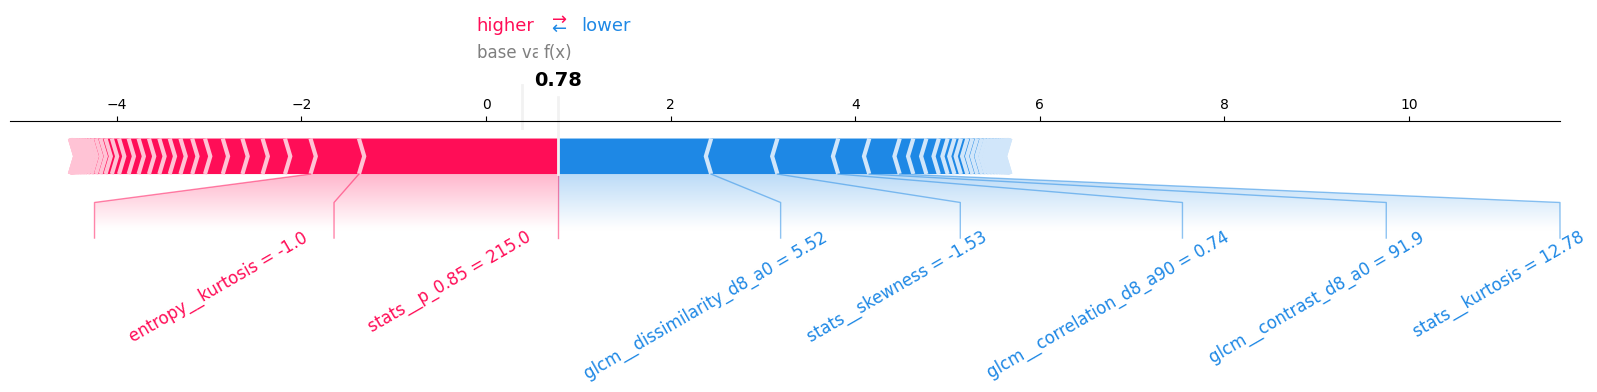

--------------------
Importance des features pour la classe prédite (junction box heat) :


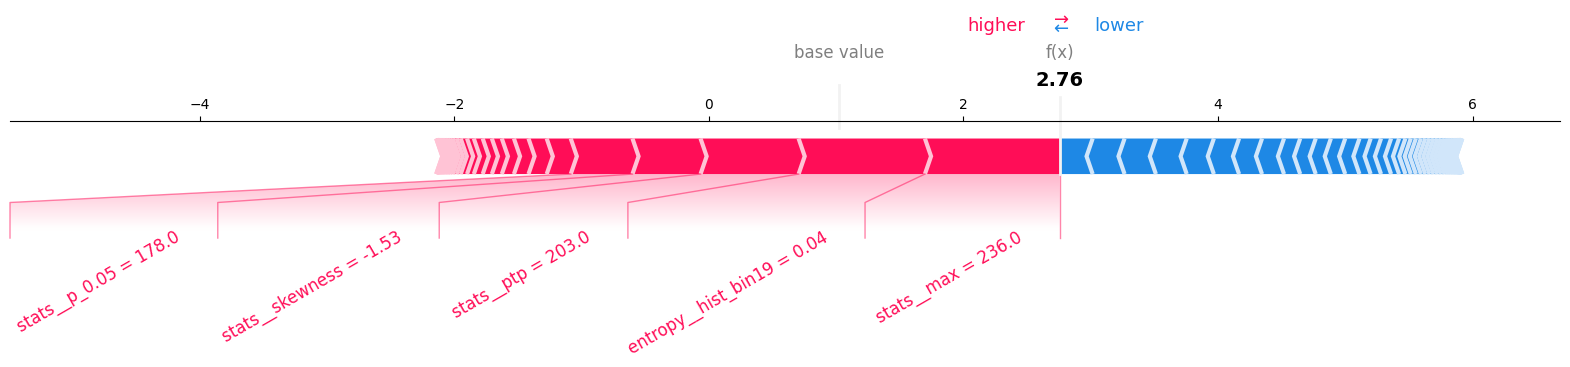

In [91]:
# Force-plot SHAP sur la classe réelle
print (f"Importance des features pour la classe réelle ({actual_class}) :")
shap.force_plot(
    explainer.expected_value[actual_class_idx], 
    shap_values[instance_idx,:,actual_class_idx], 
    np.round(X_test_transformed.iloc[instance_idx].values,2), # On arrondit les valeurs pour la présentation du graphique
    feature_names = X_test_transformed.columns,
    contribution_threshold = 0.05, # On n'affiche que les features les + importantes
    text_rotation=30,
    matplotlib=True,
)
print ("-"*20)

# Force-plot SHAP sur la classe prédite
print (f"Importance des features pour la classe prédite ({predicted_class}) :")
shap.force_plot(
    explainer.expected_value[predicted_class_idx], 
    shap_values[instance_idx,:,predicted_class_idx], 
    np.round(X_test_transformed.iloc[instance_idx].values,2), # On arrondit les valeurs pour la présentation du graphique
    feature_names = X_test_transformed.columns,
    contribution_threshold = 0.05, # On n'affiche que les features les + importantes
    text_rotation=30,
    matplotlib=True,
)

**Constatations** :

A écrire...